## SF crime data analysis and modeling

In [0]:
from csv import reader
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

os.environ["PYSPARK_PYTHON"] = "python3"

In [0]:

import urllib.request
urllib.request.urlretrieve("https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD", "/tmp/myxxxx.csv")
dbutils.fs.mv("file:/tmp/myxxxx.csv", "dbfs:/laioffer/spark_hw1/data/sf_03_18.csv")
display(dbutils.fs.ls("dbfs:/laioffer/spark_hw1/data/"))



path name size dbfs:/laioffer/spark_hw1/data/sf_03_18.csv sf_03_18.csv 550945238

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, to_timestamp, hour
from pyspark.sql.functions import year, month, dayofmonth, date_format
from pyspark.sql.functions import from_unixtime, unix_timestamp
from datetime import datetime

# create SparkSession entry to handle data
spark = SparkSession.builder \
        .appName("crime analysis") \
        .config("spark.some.config.option","some-value") \
        .getOrCreate()

# load csv data and create a table called sf_crime

data_path = "dbfs:/laioffer/spark_hw1/data/sf_03_18.csv"
df_opt = spark.read.format("csv").option("header", "true").load(data_path)

# # decompose date

date_func =  udf (lambda x: datetime.strptime(x, '%m/%d/%Y'), DateType())
#month_func = udf (lambda x: datetime.strptime(x, '%m/%d/%Y').strftime('%Y/%m'), StringType())
month_func = udf (lambda x: datetime.strptime(x, '%m/%d/%Y').strftime('%m'), StringType())
year_func = udf(lambda x: datetime.strptime(x,"%m/%d/%Y").strftime("%Y"), StringType())

#df = df_opt1.withColumn('month', month_func(col('Date'))) \
#            .withColumn('year', year_func(col('Date'))) \
#            .withColumn('Date_time', date_func(col('Date')))


df_opt = df_opt.withColumn('Hour', hour(df_opt['Time']))
# convert string to date type using unix_timestamp
df_opt = df_opt.withColumn("Month",  month_func(df_opt.Date))
df_opt = df_opt.withColumn("Date",  to_date( from_unixtime(unix_timestamp(df_opt['Date'], 'MM/dd/yyy'))))
df_opt = df_opt.withColumn("Year",  year(df_opt.Date))
df_opt = df_opt.withColumn("Day",  dayofmonth(df_opt.Date))
df_opt = df_opt.withColumn('HasCriminal', (df_opt["category"]!="NON-CRIMINAL"))
df_opt = df_opt.withColumn("X",  df_opt["X"].cast("double"))
df_opt = df_opt.withColumn("Y",  df_opt["Y"].cast("double"))

df_opt = df_opt.filter(df_opt.PdDistrict !="NA") # drop row that missing PdDistirct info
df_opt.createOrReplaceTempView("sf_crime")

In [0]:
display(df_opt)

PdId IncidntNum Incident Code Category Descript DayOfWeek Date Time PdDistrict Resolution Address X Y location SF Find Neighborhoods 2 2 Current Police Districts 2 2 Current Supervisor Districts 2 2 Analysis Neighborhoods 2 2 DELETE - Fire Prevention Districts 2 2 DELETE - Police Districts 2 2 DELETE - Supervisor Districts 2 2 DELETE - Zip Codes 2 2 DELETE - Neighborhoods 2 2 DELETE - 2017 Fix It Zones 2 2 Civic Center Harm Reduction Project Boundary 2 2 Fix It Zones as of 2017-11-06 2 2 DELETE - HSOC Zones 2 2 Fix It Zones as of 2018-02-07 2 2 CBD, BID and GBD Boundaries as of 2017 2 2 Areas of Vulnerability, 2016 2 2 Central Market/Tenderloin Boundary 2 2 Central Market/Tenderloin Boundary Polygon - Updated 2 2 HSOC Zones as of 2018-06-05 2 2 OWED Public Spaces 2 2 Neighborhoods 2 Hour Month Year Day HasCriminal 3114751606302 031147516 06302 LARCENY/THEFT PETTY THEFT FROM A BUILDING Sunday 2003-09-28 10:00 SOUTHERN NONE 1ST ST / BRANNAN ST -120.5 90.0 POINT (-120.50000000000001 90) null null null null null null null null null null null null null null null null null null null null null 10 09 2003 28 true 5069701104134 050697011 04134 ASSAULT BATTERY Wednesday 2005-06-22 12:20 NORTHERN NONE 1200 Block of EDDY ST -122.428223303176 37.7818959488603 POINT (-122.42822330317601 37.7818959488603) 97 4 11 39 7 9 11 29490 41 null null null null null null 2 null null null null 97 12 06 2005 22 true 6074729204104 060747292 04104 ASSAULT ASSAULT Saturday 2006-07-15 00:55 CENTRAL NONE 1600 Block of POWELL ST -122.410672425337 37.799788690123 POINT (-122.41067242533701 37.799788690123) 106 6 3 6 3 1 10 308 4 null null null null null null 2 null null null null 106 0 07 2006 15 true 7103536315201 071035363 15201 ASSAULT STALKING Tuesday 2007-09-25 00:01 TARAVAL NONE 400 Block of ULLOA ST -122.458226300605 37.7413616001449 POINT (-122.458226300605 37.7413616001449) 49 10 8 41 1 8 4 59 40 null null null null null null 1 null null null null 49 0 09 2007 25 true 11082415274000 110824152 74000 MISSING PERSON MISSING ADULT Saturday 2011-09-24 11:00 TARAVAL LOCATED 3200 Block of SAN JOSE AV -122.459172646607 37.7082001648459 POINT (-122.459172646607 37.7082001648459) null null null null null null null 28588 null null null null null null null null null null null null null 11 09 2011 24 true 4037801104134 040378011 04134 ASSAULT BATTERY Friday 2003-12-12 12:00 SOUTHERN NONE 500 Block of I-80 -122.386667033903 37.7898821569191 POINT (-122.38666703390301 37.7898821569191) null null null null null null null 28856 null null null null null null null null null null null null null 12 12 2003 12 true 4147669007025 041476690 07025 VEHICLE THEFT STOLEN TRUCK Thursday 2004-12-30 19:00 BAYVIEW NONE 100 Block of KAREN CT -122.407531316146 37.723291086507 POINT (-122.40753131614602 37.723291086507) 91 2 2 25 10 3 7 309 28 null null null null null null 1 null null null null 91 19 12 2004 30 true 16010127305073 160101273 05073 BURGLARY BURGLARY, UNLAWFUL ENTRY Wednesday 2016-02-03 20:30 MISSION ARREST, BOOKED 2300 Block of 16TH ST -122.40952991327822 37.76571843952822 POINT (-122.40952991327822 37.76571843952822) 53 3 9 20 8 4 8 28853 19 null null null 3 null null 2 null null 3 null 53 20 02 2016 3 true 17004924306243 170049243 06243 LARCENY/THEFT PETTY THEFT FROM LOCKED AUTO Wednesday 2017-01-18 18:20 TARAVAL NONE NORIEGA ST / SUNSET BL -122.49522504431104 37.75341185338174 POINT (-122.49522504431104 37.75341185338174) 39 10 7 35 1 8 3 56 35 null null null null null null 1 null null null null 39 18 01 2017 18 true 16065828006244 160658280 06244 LARCENY/THEFT GRAND THEFT FROM LOCKED AUTO Sunday 2016-08-14 21:00 TARAVAL NONE 3200 Block of 20TH AV -122.47564746078615 37.72852806274646 POINT (-122.47564746078615 37.72852806274647) 41 10 8 16 1 8 4 64 14 null null null null null null 2 null null null null 41 21 08 2016 14 true 18032260316100 180322603 16100 DRUG/NARCOTIC POSSESSION OF HEROIN Tuesday 2018-05-01 13:27 SOUTHERN ARREST, BOOKED 600 Block of STEVENSON ST -122

##### counts the number of crimes for different category.

In [0]:
q1_result = df_opt.groupBy('category').count().orderBy('count', ascending=False)
display(q1_result)

category count LARCENY/THEFT 477974 OTHER OFFENSES 301874 NON-CRIMINAL 236928 ASSAULT 167042 VEHICLE THEFT 126228 DRUG/NARCOTIC 117821 VANDALISM 114718 WARRANTS 99821 BURGLARY 91067 SUSPICIOUS OCC 79087 ROBBERY 54467 MISSING PERSON 44268 FRAUD 41348 FORGERY/COUNTERFEITING 22995 SECONDARY CODES 22378 WEAPON LAWS 21004 TRESPASS 19194 PROSTITUTION 16501 STOLEN PROPERTY 11450 DISORDERLY CONDUCT 9932 DRUNKENNESS 9760 SEX OFFENSES, FORCIBLE 8747 RECOVERED VEHICLE 8688 DRIVING UNDER THE INFLUENCE 5652 KIDNAPPING 4282 ARSON 3875 EMBEZZLEMENT 2984 LIQUOR LAWS 2840 LOITERING 2402 SUICIDE 1291 BAD CHECKS 924 BRIBERY 796 EXTORTION 729 GAMBLING 343 PORNOGRAPHY/OBSCENE MAT 57 SEX OFFENSES, NON FORCIBLE 43 TREA 14

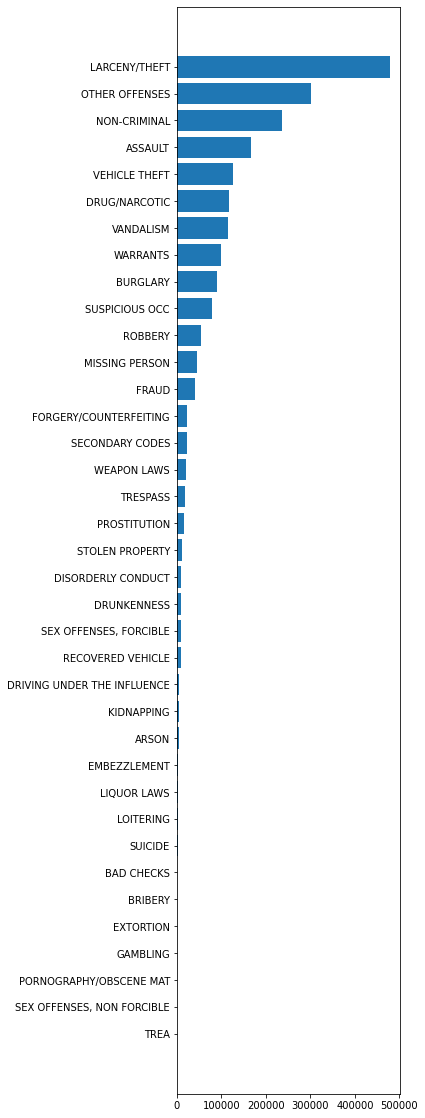

In [0]:

crimes_pd_df = crimeCategory.toPandas()
crimes_pd_df.sort_values('Count',inplace=True)


plt.figure(figsize=(4,20))
plt.barh(crimes_pd_df["category"],crimes_pd_df["Count"])
plt.show()

#display(p)

In San Francisco, the most common crime is Larceny or theft, the 2nd common crime is other offenses.

Counts the number of crimes for different district, and visualize your results

In [0]:
crimes_district = spark.sql("""
SELECT PdDistrict AS Distirct, COUNT(*) AS counts 
FROM (SELECT PdDistrict, Category FROM sf_crime
       WHERE Category != "NON-CRIMINAL")
GROUP BY PdDistrict 
ORDER BY counts DESC
""")
#crimes_district = crimes_district.na.fill("unknown")
display(crimes_district)



Distirct counts SOUTHERN 340988 MISSION 257385 NORTHERN 240054 CENTRAL 193348 BAYVIEW 189619 TENDERLOIN 168208 INGLESIDE 163661 TARAVAL 137183 PARK 104290 RICHMOND 97860

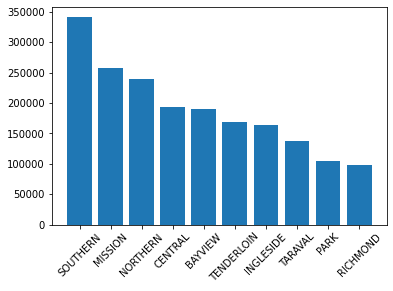

In [0]:
crimes_district_pd = crimes_district.toPandas()
plt.bar(crimes_district_pd["Distirct"], crimes_district_pd["counts"])
plt.xticks(rotation = 45)
plt.show()

Southern district is the most dangerous place as it has the highest crime occurance. Park and Richmond is most safe place.    
Now, let's take a look of the top 5 crime categories in each District.

In [0]:
top_5 = spark.sql("""
WITH count(
SELECT PdDistrict AS District, Category, count(*) as count 
FROM (SELECT PdDistrict, Category FROM sf_crime
       WHERE Category != "NON-CRIMINAL")
GROUP BY PdDistrict, Category)

SELECT * FROM
(SELECT District, Category, count, RANK()OVER (PARTITION BY District ORDER BY count DESC) AS rank FROM count)
WHERE rank <=5
""")

display(top_5)

District Category count rank BAYVIEW OTHER OFFENSES 39717 1 BAYVIEW LARCENY/THEFT 27638 2 BAYVIEW ASSAULT 20016 3 BAYVIEW VEHICLE THEFT 16780 4 BAYVIEW VANDALISM 13915 5 CENTRAL LARCENY/THEFT 71808 1 CENTRAL OTHER OFFENSES 22241 2 CENTRAL ASSAULT 15822 3 CENTRAL VANDALISM 12517 4 CENTRAL BURGLARY 11161 5 INGLESIDE OTHER OFFENSES 31444 1 INGLESIDE LARCENY/THEFT 25717 2 INGLESIDE VEHICLE THEFT 20546 3 INGLESIDE ASSAULT 16949 4 INGLESIDE VANDALISM 12890 5 MISSION LARCENY/THEFT 48811 1 MISSION OTHER OFFENSES 46377 2 MISSION ASSAULT 25312 3 MISSION DRUG/NARCOTIC 18957 4 MISSION VEHICLE THEFT 17297 5 NORTHERN LARCENY/THEFT 80859 1 NORTHERN OTHER OFFENSES 30311 2 NORTHERN ASSAULT 18524 3 NORTHERN VEHICLE THEFT 14780 4 NORTHERN VANDALISM 14418 5 PARK LARCENY/THEFT 25342 1 PARK OTHER OFFENSES 15537 2 PARK VEHICLE THEFT 9491 3 PARK ASSAULT 7405 4 PARK BURGLARY 7071 5 RICHMOND LARCENY/THEFT 29056 1 RICHMOND OTHER OFFENSES 13968 2 RICHMOND VEHICLE THEFT 9605 3 RICHMOND VANDALISM 7754 4 RICHMOND ASSAULT 6624 5 SOUTHERN LARCENY/THEFT 112712 1 SOUTHERN OTHER OFFENSES 50482 2 SOUTHERN ASSAULT 28467 3 SOUTHERN WARRANTS 21775 4 SOUTHERN DRUG/NARCOTIC 20697 5 TARAVAL LARCENY/THEFT 31726 1 TARAVAL OTHER OFFENSES 21723 2 TARAVAL VEHICLE THEFT 13966 3 TARAVAL VANDALISM 11402 4 TARAVAL ASSAULT 10844 5 TENDERLOIN DRUG/NARCOTIC 37800 1 TENDERLOIN OTHER OFFENSES 30074 2 TENDERLOIN LARCENY/THEFT 24305 3 TENDERLOIN ASSAULT 17079 4 TENDERLOIN WARRANTS 16406 5

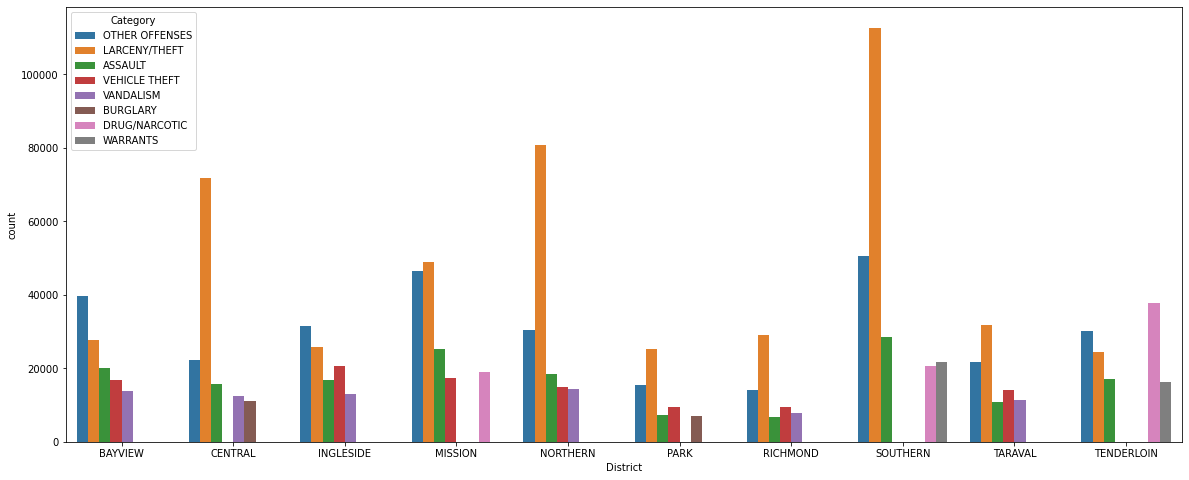

In [0]:
top5_pd = top_5.toPandas()
plt.figure(figsize=(20, 8))
sns.barplot(x="District", y="count", hue="Category", data=top5_pd, ci=None);

We can tell from the above plot, the top 5 crime type in each Disctirct are different. At Central, Northern and Southern, Larceny/Theft represent very high percentage of the overall crime. At Bayview, Other offenses is the most occurance crime. Park, Richmond and Taraval are safe place to live

Count the number of crimes each "Sunday" at "SF downtown".

In [0]:
from pyspark.sql.functions import col, udf
import math
def downtown(x,y):
  x = float(x)
  y = float(y)
  #if math.sqrt((x-32.781172)**2 + (y-96.797666)**2 ) <0.015:
  if -122.4213 <= x<=-22.4313 and 37.7540 <=y <= 37.7740:
     return "Downtown"
  return "Outside Downtown"

downtown_func = udf(lambda x,y: downtown(x,y) if x and y else None, StringType())
df_opt= df_opt.withColumn("downtown",downtown_func(col("X"),col("Y")) )
display(df_opt)

PdId IncidntNum Incident Code Category Descript DayOfWeek Date Time PdDistrict Resolution Address X Y location SF Find Neighborhoods 2 2 Current Police Districts 2 2 Current Supervisor Districts 2 2 Analysis Neighborhoods 2 2 DELETE - Fire Prevention Districts 2 2 DELETE - Police Districts 2 2 DELETE - Supervisor Districts 2 2 DELETE - Zip Codes 2 2 DELETE - Neighborhoods 2 2 DELETE - 2017 Fix It Zones 2 2 Civic Center Harm Reduction Project Boundary 2 2 Fix It Zones as of 2017-11-06 2 2 DELETE - HSOC Zones 2 2 Fix It Zones as of 2018-02-07 2 2 CBD, BID and GBD Boundaries as of 2017 2 2 Areas of Vulnerability, 2016 2 2 Central Market/Tenderloin Boundary 2 2 Central Market/Tenderloin Boundary Polygon - Updated 2 2 HSOC Zones as of 2018-06-05 2 2 OWED Public Spaces 2 2 Neighborhoods 2 Hour Month Year Day HasCriminal downtown 3114751606302 031147516 06302 LARCENY/THEFT PETTY THEFT FROM A BUILDING Sunday 2003-09-28 10:00 SOUTHERN NONE 1ST ST / BRANNAN ST -120.5 90.0 POINT (-120.50000000000001 90) null null null null null null null null null null null null null null null null null null null null null 10 09 2003 28 true Outside Downtown 5069701104134 050697011 04134 ASSAULT BATTERY Wednesday 2005-06-22 12:20 NORTHERN NONE 1200 Block of EDDY ST -122.428223303176 37.7818959488603 POINT (-122.42822330317601 37.7818959488603) 97 4 11 39 7 9 11 29490 41 null null null null null null 2 null null null null 97 12 06 2005 22 true Outside Downtown 6074729204104 060747292 04104 ASSAULT ASSAULT Saturday 2006-07-15 00:55 CENTRAL NONE 1600 Block of POWELL ST -122.410672425337 37.799788690123 POINT (-122.41067242533701 37.799788690123) 106 6 3 6 3 1 10 308 4 null null null null null null 2 null null null null 106 0 07 2006 15 true Outside Downtown 7103536315201 071035363 15201 ASSAULT STALKING Tuesday 2007-09-25 00:01 TARAVAL NONE 400 Block of ULLOA ST -122.458226300605 37.7413616001449 POINT (-122.458226300605 37.7413616001449) 49 10 8 41 1 8 4 59 40 null null null null null null 1 null null null null 49 0 09 2007 25 true Outside Downtown 11082415274000 110824152 74000 MISSING PERSON MISSING ADULT Saturday 2011-09-24 11:00 TARAVAL LOCATED 3200 Block of SAN JOSE AV -122.459172646607 37.7082001648459 POINT (-122.459172646607 37.7082001648459) null null null null null null null 28588 null null null null null null null null null null null null null 11 09 2011 24 true Outside Downtown 4037801104134 040378011 04134 ASSAULT BATTERY Friday 2003-12-12 12:00 SOUTHERN NONE 500 Block of I-80 -122.386667033903 37.7898821569191 POINT (-122.38666703390301 37.7898821569191) null null null null null null null 28856 null null null null null null null null null null null null null 12 12 2003 12 true Outside Downtown 4147669007025 041476690 07025 VEHICLE THEFT STOLEN TRUCK Thursday 2004-12-30 19:00 BAYVIEW NONE 100 Block of KAREN CT -122.407531316146 37.723291086507 POINT (-122.40753131614602 37.723291086507) 91 2 2 25 10 3 7 309 28 null null null null null null 1 null null null null 91 19 12 2004 30 true Outside Downtown 16010127305073 160101273 05073 BURGLARY BURGLARY, UNLAWFUL ENTRY Wednesday 2016-02-03 20:30 MISSION ARREST, BOOKED 2300 Block of 16TH ST -122.40952991327822 37.76571843952822 POINT (-122.40952991327822 37.76571843952822) 53 3 9 20 8 4 8 28853 19 null null null 3 null null 2 null null 3 null 53 20 02 2016 3 true Downtown 17004924306243 170049243 06243 LARCENY/THEFT PETTY THEFT FROM LOCKED AUTO Wednesday 2017-01-18 18:20 TARAVAL NONE NORIEGA ST / SUNSET BL -122.49522504431104 37.75341185338174 POINT (-122.49522504431104 37.75341185338174) 39 10 7 35 1 8 3 56 35 null null null null null null 1 null null null null 39 18 01 2017 18 true Outside Downtown 16065828006244 160658280 06244 LARCENY/THEFT GRAND THEFT FROM LOCKED AUTO Sunday 2016-08-14 21:00 TARAVAL NONE 3200 Block of 20TH AV -122.47564746078615 37.72852806274646 POINT (-122.47564746078615 37.72852806274647) 41 10 8 16 1 8 4 64 14 null null null null null null 2 null null null null 41 21 08 2016

In [0]:
df_opt.createOrReplaceTempView("sf_crime")
downtown_sunday = spark.sql("""
SELECT Date, COUNT(*) AS count 
FROM sf_crime 
WHERE downtown = 'Downtown' 
and DayOfWeek = 'Sunday' 
and Category != 'NON-CRIMINAL'
GROUP BY Date
ORDER BY Date""")
display(downtown_sunday )


Date count 2003-01-05 40 2003-01-12 27 2003-01-19 28 2003-01-26 28 2003-02-02 34 2003-02-09 26 2003-02-16 18 2003-02-23 43 2003-03-02 48 2003-03-09 31 2003-03-16 30 2003-03-23 24 2003-03-30 30 2003-04-06 28 2003-04-13 29 2003-04-20 30 2003-04-27 25 2003-05-04 40 2003-05-11 38 2003-05-18 25 2003-05-25 30 2003-06-01 38 2003-06-08 41 2003-06-15 43 2003-06-22 44 2003-06-29 31 2003-07-06 30 2003-07-13 27 2003-07-20 35 2003-07-27 35 2003-08-03 40 2003-08-10 26 2003-08-17 30 2003-08-24 28 2003-08-31 23 2003-09-07 47 2003-09-14 37 2003-09-21 44 2003-09-28 39 2003-10-05 18 2003-10-12 39 2003-10-19 23 2003-10-26 34 2003-11-02 29 2003-11-09 24 2003-11-16 34 2003-11-23 23 2003-11-30 33 2003-12-07 10 2003-12-14 25 2003-12-21 55 2003-12-28 22 2004-01-04 32 2004-01-11 32 2004-01-18 22 2004-01-25 41 2004-02-01 27 2004-02-08 25 2004-02-15 46 2004-02-22 33 2004-02-29 37 2004-03-07 33 2004-03-14 24 2004-03-21 34 2004-03-28 40 2004-04-04 31 2004-04-11 28 2004-04-18 38 2004-04-25 47 2004-05-02 29 2004-05-09 40 2004-05-16 40 2004-05-23 26 2004-05-30 41 2004-06-06 24 2004-06-13 25 2004-06-20 33 2004-06-27 36 2004-07-04 37 2004-07-11 27 2004-07-18 36 2004-07-25 26 2004-08-01 48 2004-08-08 23 2004-08-15 34 2004-08-22 27 2004-08-29 40 2004-09-05 31 2004-09-12 33 2004-09-19 17 2004-09-26 30 2004-10-03 30 2004-10-10 26 2004-10-17 30 2004-10-24 27 2004-10-31 38 2004-11-07 32 2004-11-14 24 2004-11-21 31 2004-11-28 39 2004-12-05 31 2004-12-12 27 2004-12-19 26 2004-12-26 19 2005-01-02 33 2005-01-09 25 2005-01-16 32 2005-01-23 34 2005-01-30 37 2005-02-06 32 2005-02-13 39 2005-02-20 28 2005-02-27 21 2005-03-06 31 2005-03-13 32 2005-03-20 30 2005-03-27 33 2005-04-03 36 2005-04-10 23 2005-04-17 32 2005-04-24 39 2005-05-01 41 2005-05-08 41 2005-05-15 45 2005-05-22 33 2005-05-29 44 2005-06-05 24 2005-06-12 42 2005-06-19 40 2005-06-26 47 2005-07-03 29 2005-07-10 29 2005-07-17 32 2005-07-24 31 2005-07-31 21 2005-08-07 33 2005-08-14 31 2005-08-21 20 2005-08-28 29 2005-09-04 21 2005-09-11 32 2005-09-18 24 2005-09-25 52 2005-10-02 39 2005-10-09 46 2005-10-16 23 2005-10-23 42 2005-10-30 28 2005-11-06 24 2005-11-13 29 2005-11-20 31 2005-11-27 26 2005-12-04 28 2005-12-11 25 2005-12-18 30 2005-12-25 24 2006-01-01 41 2006-01-08 25 2006-01-15 32 2006-01-22 36 2006-01-29 26 2006-02-05 10 2006-02-12 45 2006-02-19 25 2006-02-26 24 2006-03-05 21 2006-03-12 27 2006-03-19 20 2006-03-26 36 2006-04-02 42 2006-04-09 23 2006-04-16 13 2006-04-23 26 2006-04-30 28 2006-05-07 26 2006-05-14 39 2006-05-21 25 2006-05-28 42 2006-06-04 52 2006-06-11 32 2006-06-18 28 2006-06-25 24 2006-07-02 14 2006-07-09 29 2006-07-16 46 2006-07-23 23 2006-07-30 36 2006-08-06 32 2006-08-13 38 2006-08-20 18 2006-08-27 21 2006-09-03 23 2006-09-10 41 2006-09-17 26 2006-09-24 20 2006-10-01 31 2006-10-08 28 2006-10-15 21 2006-10-22 30 2006-10-29 22 2006-11-05 23 2006-11-12 29 2006-11-19 23 2006-11-26 22 2006-12-03 38 2006-12-10 29 2006-12-17 22 2006-12-24 24 2006-12-31 41 2007-01-07 29 2007-01-14 27 2007-01-21 50 2007-01-28 25 2007-02-04 35 2007-02-11 24 2007-02-18 36 2007-02-25 23 2007-03-04 41 2007-03-11 19 2007-03-18 36 2007-03-25 29 2007-04-01 31 2007-04-08 29 2007-04-15 20 2007-04-22 32 2007-04-29 31 2007-05-06 36 2007-05-13 25 2007-05-20 19 2007-05-27 27 2007-06-03 37 2007-06-10 22 2007-06-17 36 2007-06-24 35 2007-07-01 38 2007-07-08 21 2007-07-15 28 2007-07-22 31 2007-07-29 35 2007-08-05 31 2007-08-12 43 2007-08-19 29 2007-08-26 34 2007-09-02 33 2007-09-09 52 2007-09-16 33 2007-09-23 59 2007-09-30 33 2007-10-07 43 2007-10-14 29 2007-10-21 44 2007-10-28 28 2007-11-04 19 2007-11-11 28 2007-11-18 46 2007-11-25 25 2007-12-02 40 2007-12-09 27 2007-12-23 31 2007-12-30 31 2008-01-06 36 2008-01-13 37 2008-01-20 48 2008-01-27 44 2008-02-03 35 2008-02-10 45 2008-02-17 38 2008-02-24 35 2008-03-02 17 2008-03-09 46 2008-03-16 27 2008-03-23 37 2008-03-30 32 2008-04-06 44 2008-04-13 37 2008-04-20 41 2008-04-27 36 2008-05-04 35 2008-05-11 26 2008-05-18 35 2008-05-25 32 2008-06-01 30 2008-06-08 27 2008-06-15 22 2008-06-22 25

Out[6]:

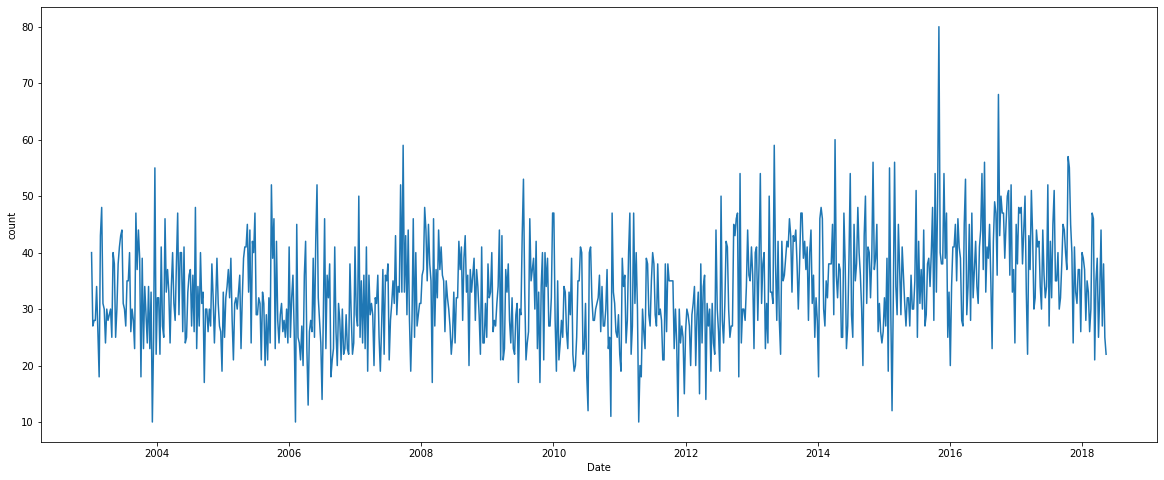

<matplotlib.axes._subplots.AxesSubplot at 0x7f19f63433a0>

In [0]:
downtown_sunday_df = downtown_sunday.toPandas()
plt.figure(figsize = (20,8))
sns.lineplot(x= "Date", y= "count", data=downtown_sunday_df )

We can tell the time series plot is unstationary, and there is upwarding trend after 2013. we may need to do some time series analysis later on.

In [0]:
downtown_sunday1 = spark.sql(
  """
  SELECT concat(year, month) as year_month, COUNT(*) AS count 
  FROM sf_crime 
  WHERE downtown = 'Downtown' 
  and DayOfWeek = 'Sunday' 
  and Category != 'NON-CRIMINAL'
  GROUP BY year_month 
  Order BY year_month
  """)
display(downtown_sunday1 )




year_month count 200301 123 200302 121 200303 163 200304 112 200305 133 200306 197 200307 127 200308 147 200309 167 200310 114 200311 143 200312 112 200401 127 200402 168 200403 131 200404 144 200405 176 200406 118 200407 126 200408 172 200409 111 200410 151 200411 126 200412 103 200501 161 200502 120 200503 126 200504 130 200505 204 200506 153 200507 142 200508 113 200509 129 200510 178 200511 110 200512 107 200601 160 200602 104 200603 104 200604 132 200605 132 200606 136 200607 148 200608 109 200609 110 200610 132 200611 97 200612 154 200701 131 200702 118 200703 125 200704 143 200705 107 200706 130 200707 153 200708 137 200709 210 200710 144 200711 118 200712 129 200801 165 200802 153 200803 159 200804 158 200805 128 200806 137 200807 130 200808 188 200809 126 200810 136 200811 163 200812 104 200901 143 200902 112 200903 163 200904 131 200905 129 200906 107 200907 158 200908 152 200909 148 200910 107 200911 174 200912 133 201001 150 201002 111 201003 115 201004 109 201005 156 201006 116 201007 111 201008 149 201009 128 201010 144 201011 116 201012 111 201101 150 201102 139 201103 127 201104 100 201105 136 201106 129 201107 172 201108 108 201109 123 201110 163 201111 95 201112 91 201201 132 201202 114 201203 115 201204 139 201205 107 201206 120 201207 147 201208 144 201209 167 201210 165 201211 112 201212 190 201301 140 201302 151 201303 156 201304 147 201305 167 201306 163 201307 168 201308 161 201309 197 201310 165 201311 153 201312 152 201401 158 201402 124 201403 188 201404 166 201405 134 201406 181 201407 134 201408 192 201409 144 201410 152 201411 203 201412 107 201501 117 201502 129 201503 201 201504 137 201505 154 201506 146 201507 135 201508 168 201509 161 201510 165 201511 250 201512 144 201601 181 201602 161 201603 153 201604 136 201605 192 201606 170 201607 206 201608 145 201609 200 201610 226 201611 182 201612 146 201701 226 201702 165 201703 153 201704 190 201705 150 201706 154 201707 197 201708 140 201709 159 201710 234 201711 138 201712 171 201801 139 201802 136 201803 141 201804 167 201805 47

Out[27]:

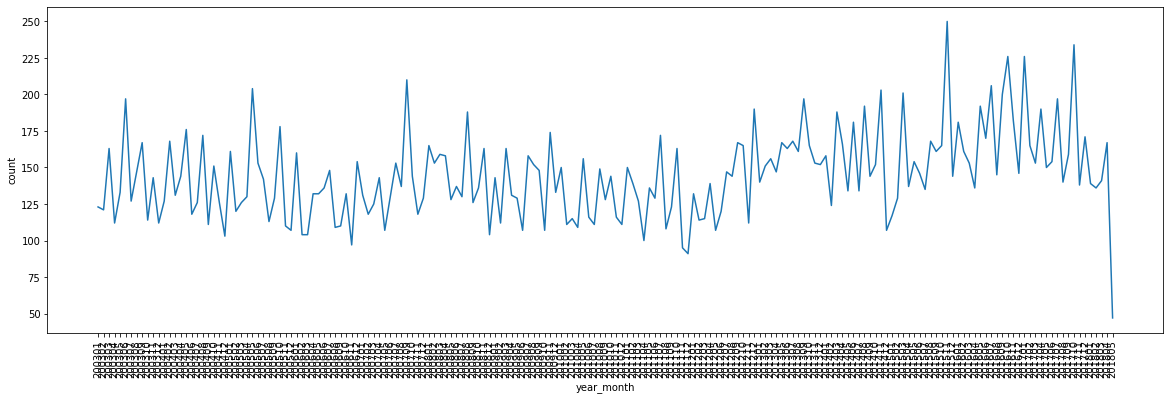

<matplotlib.axes._subplots.AxesSubplot at 0x7fdbc0133820>

In [0]:
downtown_sunday_df1 = downtown_sunday1.toPandas()
plt.figure(figsize = (20,6))
plt.xticks(rotation=90)
sns.lineplot(x= "year_month", y= "count", data=downtown_sunday_df1, ci = None)


We can tell the trend more clear after count the criminal by Month for SF Downtown friday.     
I'm also interested in the crime occurrence for each day of week at SF downtown and see which day is most unsafe day for each month

In [0]:
downtown1 = spark.sql(
  """
  SELECT DayOfWeek, COUNT(*) AS count 
  FROM sf_crime
  WHERE downtown = 'Downtown'
  and Category != 'NON-CRIMINAL'
  GROUP BY DayOfWeek
  ORDER BY DayOfWeek
  """ )
display(downtown1)

DayOfWeek count Friday 31332 Monday 27764 Saturday 29079 Sunday 26768 Thursday 30129 Tuesday 30065 Wednesday 30856

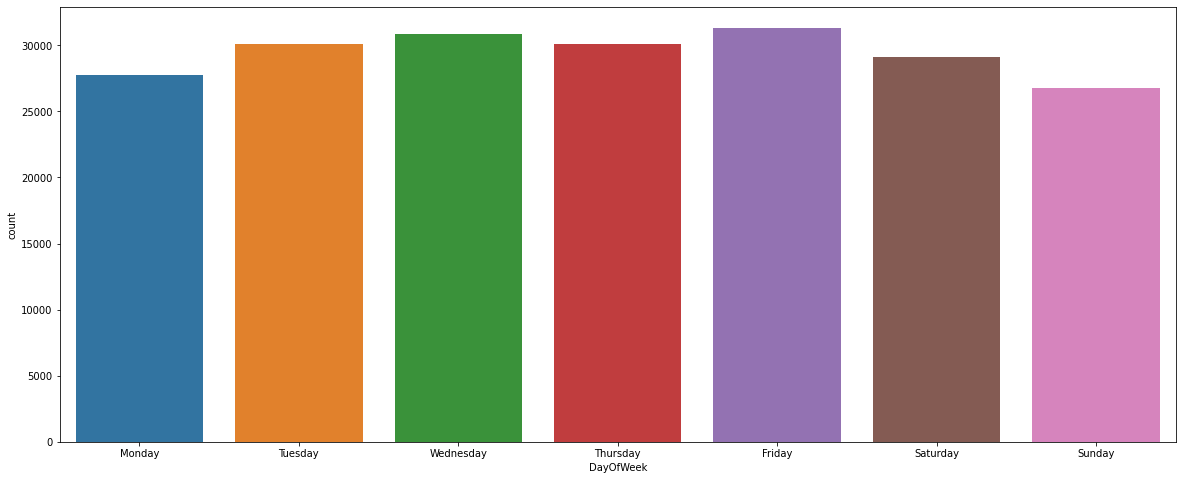

In [0]:
downtown_pd = downtown1.toPandas()
plt.figure(figsize=(20, 8))
sns.barplot(x="DayOfWeek", y="count", data=downtown_pd, ci=None, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday']); 

In [0]:
downtown2 = spark.sql(
  """
  SELECT DayOfWeek, month, COUNT(*) AS count 
  FROM sf_crime
  WHERE downtown = 'Downtown'
  and Category != 'NON-CRIMINAL'
  GROUP BY DayOfWeek, month 
  ORDER BY month, DayOfWeek
  """ )
display(downtown2)

DayOfWeek month count Friday 01 2823 Monday 01 2424 Saturday 01 2652 Sunday 01 2403 Thursday 01 2823 Tuesday 01 2794 Wednesday 01 2883 Friday 02 2579 Monday 02 2330 Saturday 02 2294 Sunday 02 2126 Thursday 02 2367 Tuesday 02 2524 Wednesday 02 2630 Friday 03 2739 Monday 03 2520 Saturday 03 2572 Sunday 03 2320 Thursday 03 2752 Tuesday 03 2538 Wednesday 03 2796 Friday 04 2729 Monday 04 2199 Saturday 04 2422 Sunday 04 2241 Thursday 04 2587 Tuesday 04 2494 Wednesday 04 2631 Friday 05 2736 Monday 05 2371 Saturday 05 2440 Sunday 05 2252 Thursday 05 2549 Tuesday 05 2604 Wednesday 05 2463 Friday 06 2471 Monday 06 2122 Saturday 06 2315 Sunday 06 2157 Thursday 06 2350 Tuesday 06 2344 Wednesday 06 2442 Friday 07 2430 Monday 07 2096 Saturday 07 2392 Sunday 07 2254 Thursday 07 2509 Tuesday 07 2398 Wednesday 07 2476 Friday 08 2564 Monday 08 2403 Saturday 08 2501 Sunday 08 2225 Thursday 08 2586 Tuesday 08 2502 Wednesday 08 2498 Friday 09 2629 Monday 09 2277 Saturday 09 2445 Sunday 09 2280 Thursday 09 2520 Tuesday 09 2403 Wednesday 09 2517 Friday 10 2701 Monday 10 2550 Saturday 10 2423 Sunday 10 2376 Thursday 10 2580 Tuesday 10 2535 Wednesday 10 2657 Friday 11 2542 Monday 11 2399 Saturday 11 2466 Sunday 11 2180 Thursday 11 2218 Tuesday 11 2557 Wednesday 11 2473 Friday 12 2389 Monday 12 2073 Saturday 12 2157 Sunday 12 1954 Thursday 12 2288 Tuesday 12 2372 Wednesday 12 2390

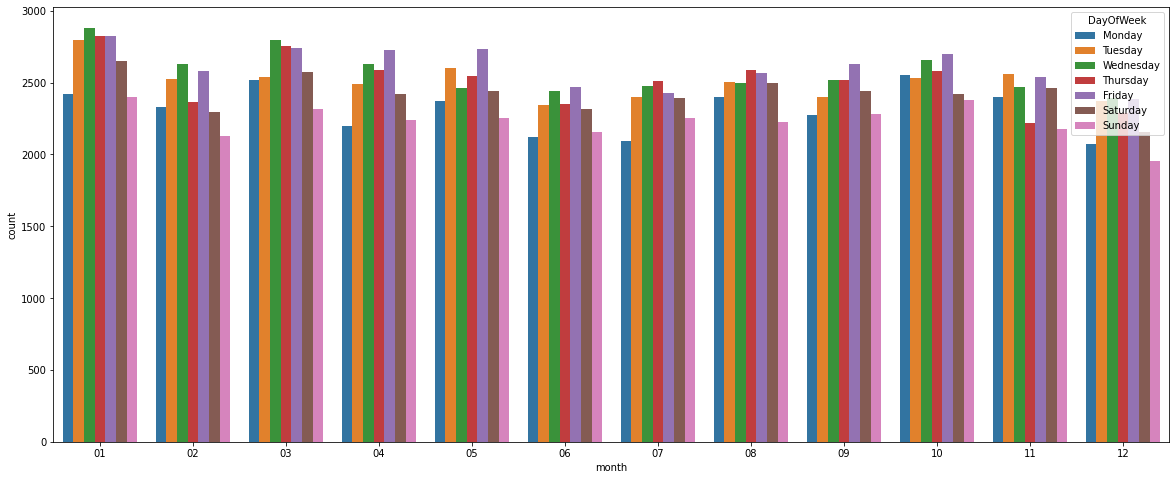

In [0]:
downtown_pd_df = downtown2.toPandas()
plt.figure(figsize=(20, 8))
sns.barplot(x="month", y="count", hue="DayOfWeek", data=downtown_pd_df, ci=None, hue_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday']); 

Based on the plot of number of crime on different day of week for each month at DownTown
, we can tell:  
* Sunday have the lowest occurence of crime for every month.
* Monday also have the lowest occurence of crime, except October and November.
* Tuesday to Saturday have the highest occurence of crime. 
* When looking at month, June, July and December has the lowest occurence of crime
* January has the highest occurence of crime.

Analysis the number of crime in each month of 2015, 2016, 2017, 2018.

In [0]:
q4 = spark.sql("""
SELECT year, month, COUNT(*) AS count FROM sf_crime 
WHERE year IN ('2015','2016','2017','2018') 
AND Category != 'NON-CRIMINAL'
GROUP BY year, month 
ORDER BY year, month
""")
display(q4)

year month count 2015 01 11509 2015 02 10332 2015 03 11735 2015 04 10903 2015 05 11693 2015 06 11275 2015 07 11361 2015 08 11598 2015 09 10887 2015 10 11120 2015 11 10172 2015 12 9776 2016 01 11038 2016 02 10263 2016 03 10379 2016 04 10258 2016 05 10706 2016 06 10298 2016 07 10383 2016 08 10734 2016 09 10595 2016 10 11409 2016 11 10917 2016 12 11142 2017 01 11260 2017 02 10409 2017 03 11662 2017 04 11093 2017 05 11301 2017 06 10762 2017 07 11267 2017 08 10919 2017 09 10696 2017 10 11510 2017 11 10558 2017 12 10722 2018 01 10351 2018 02 8451 2018 03 9175 2018 04 8771 2018 05 3072

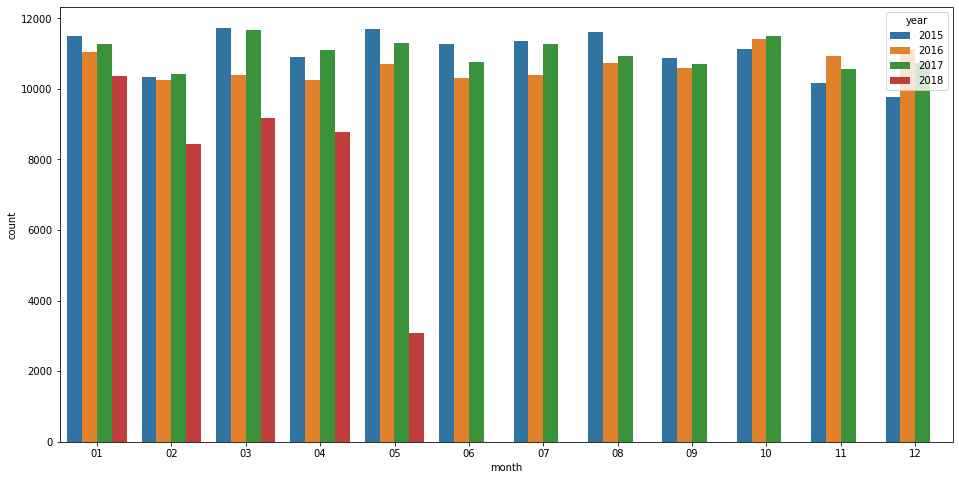

In [0]:
q4_pd = q4.toPandas()
plt.figure(figsize=(16, 8))
sns.barplot(x="month", y="count", hue="year", data=q4_pd, ci=None);


We don't have the entire data for year 2018, but based on the first 4 month, we can tell, in year of 2018, the puliic security is kind of restored, the cirminal is much less than the previous three years. Some action might token during that period  
The public security was better in year of 2016, but after October it get worse.

Analysis the number of crime with respsect to the hour in certian day like 2015/12/15, 2016/12/15, 2017/12/15. give travel suggestion to visit SF.

In [0]:
display(df_opt)

PdId IncidntNum Incident Code Category Descript DayOfWeek Date Time PdDistrict Resolution Address X Y location SF Find Neighborhoods 2 2 Current Police Districts 2 2 Current Supervisor Districts 2 2 Analysis Neighborhoods 2 2 DELETE - Fire Prevention Districts 2 2 DELETE - Police Districts 2 2 DELETE - Supervisor Districts 2 2 DELETE - Zip Codes 2 2 DELETE - Neighborhoods 2 2 DELETE - 2017 Fix It Zones 2 2 Civic Center Harm Reduction Project Boundary 2 2 Fix It Zones as of 2017-11-06 2 2 DELETE - HSOC Zones 2 2 Fix It Zones as of 2018-02-07 2 2 CBD, BID and GBD Boundaries as of 2017 2 2 Areas of Vulnerability, 2016 2 2 Central Market/Tenderloin Boundary 2 2 Central Market/Tenderloin Boundary Polygon - Updated 2 2 HSOC Zones as of 2018-06-05 2 2 OWED Public Spaces 2 2 Neighborhoods 2 Hour Month Year Day HasCriminal downtown 3114751606302 031147516 06302 LARCENY/THEFT PETTY THEFT FROM A BUILDING Sunday 2003-09-28 10:00 SOUTHERN NONE 1ST ST / BRANNAN ST -120.5 90.0 POINT (-120.50000000000001 90) null null null null null null null null null null null null null null null null null null null null null 10 09 2003 28 true Outside Downtown 5069701104134 050697011 04134 ASSAULT BATTERY Wednesday 2005-06-22 12:20 NORTHERN NONE 1200 Block of EDDY ST -122.428223303176 37.7818959488603 POINT (-122.42822330317601 37.7818959488603) 97 4 11 39 7 9 11 29490 41 null null null null null null 2 null null null null 97 12 06 2005 22 true Outside Downtown 6074729204104 060747292 04104 ASSAULT ASSAULT Saturday 2006-07-15 00:55 CENTRAL NONE 1600 Block of POWELL ST -122.410672425337 37.799788690123 POINT (-122.41067242533701 37.799788690123) 106 6 3 6 3 1 10 308 4 null null null null null null 2 null null null null 106 0 07 2006 15 true Outside Downtown 7103536315201 071035363 15201 ASSAULT STALKING Tuesday 2007-09-25 00:01 TARAVAL NONE 400 Block of ULLOA ST -122.458226300605 37.7413616001449 POINT (-122.458226300605 37.7413616001449) 49 10 8 41 1 8 4 59 40 null null null null null null 1 null null null null 49 0 09 2007 25 true Outside Downtown 11082415274000 110824152 74000 MISSING PERSON MISSING ADULT Saturday 2011-09-24 11:00 TARAVAL LOCATED 3200 Block of SAN JOSE AV -122.459172646607 37.7082001648459 POINT (-122.459172646607 37.7082001648459) null null null null null null null 28588 null null null null null null null null null null null null null 11 09 2011 24 true Outside Downtown 4037801104134 040378011 04134 ASSAULT BATTERY Friday 2003-12-12 12:00 SOUTHERN NONE 500 Block of I-80 -122.386667033903 37.7898821569191 POINT (-122.38666703390301 37.7898821569191) null null null null null null null 28856 null null null null null null null null null null null null null 12 12 2003 12 true Outside Downtown 4147669007025 041476690 07025 VEHICLE THEFT STOLEN TRUCK Thursday 2004-12-30 19:00 BAYVIEW NONE 100 Block of KAREN CT -122.407531316146 37.723291086507 POINT (-122.40753131614602 37.723291086507) 91 2 2 25 10 3 7 309 28 null null null null null null 1 null null null null 91 19 12 2004 30 true Outside Downtown 18030800164070 180308001 64070 SUSPICIOUS OCC SUSPICIOUS OCCURRENCE Wednesday 2018-04-25 05:00 BAYVIEW NONE 1400 Block of THOMAS AV -122.38854283127222 37.72878928885484 POINT (-122.38854283127222 37.72878928885484) 86 2 9 1 10 3 8 58 1 null null null null null null 2 null null null null 86 5 04 2018 25 true Outside Downtown 18023216504170 180232165 04170 ASSAULT FALSE IMPRISONMENT Saturday 2018-03-24 07:00 MISSION NONE MISSION ST / 20TH ST -122.41905269434928 37.75863240515618 POINT (-122.41905269434928 37.75863240515618) 53 3 2 20 2 4 7 28859 19 13 null 15 3 15 null 2 null null 3 null 53 7 03 2018 24 true Downtown 16028516271000 160285162 71000 NON-CRIMINAL LOST PROPERTY Tuesday 2016-03-01 00:01 MISSION NONE 2200 Block of MARKET ST -122.43195768519577 37.76493571896795 POINT (-122.43195768519577 37.76493571896795) 38 3 5 5 15 4 5 28862 3 null null null 5 null 9 1 null null 5 null 38 0 03 2016 1 false Outside Downtown 17103493468020 171034934 6802

In [0]:
hour_func= udf(lambda x: int(x[:2]) if x else None, IntegerType())
#downtown_func = udf(lambda x,y: downtown(x,y) if x and y else None, StringType())
df =df.withColumn("hour", hour_func(col("Time")) )
display(df)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-2342520613824990> in <module> 
 1 hour_func = udf ( lambda x : int ( x [ : 2 ] ) if x else None , IntegerType ( ) ) 
 2 #downtown_func = udf(lambda x,y: downtown(x,y) if x and y else None, StringType()) 
 ----> 3 df = df . withColumn ( "hour" , hour_func ( col ( "Time" ) ) ) 
 4 display ( df ) 

 NameError : name 'df' is not defined

In [0]:
#df.createOrReplaceTempView("sf_crime")
#downtown_crime.createOrReplaceTempView("downtown_crime")
q5_20151215 = spark.sql("""
SELECT hour, COUNT(*) as count FROM sf_crime
WHERE Date = "2015-12-15"
AND Category != 'NON-CRIMINAL'
GROUP BY hour
ORDER BY hour

""")
display(q5_20151215)

hour count 0 14 1 6 2 5 3 4 4 8 5 3 6 3 7 6 8 10 9 9 10 22 11 14 12 27 13 11 14 23 15 14 16 23 17 17 18 16 19 26 20 13 21 10 22 13 23 8

Let take 2015-12-15 as an example, we can tell there are some hour have high crime rate than other hours. like lunch time had the highest number of crime, early morning had the lowest number of cirme. however one day cannot present entire year, next step, let's count the number of crime for each hour for the entire year.

In [0]:
q_hour = spark.sql("""
SELECT hour, count(*) as count FROM sf_crime
WHERE Category != 'NON-CRIMINAL'
GROUP BY hour
ORDER BY hour

""")
display(q_hour)

hour count 0 98196 1 57505 2 48361 3 31481 4 22269 5 19538 6 28244 7 45488 8 68074 9 74175 10 78807 11 80793 12 110112 13 90458 14 93911 15 100351 16 106008 17 116688 18 123063 19 110829 20 100406 21 95445 22 100090 23 92304

Based on the result, 5am is the safetest time, from 1am to 7am are also safe, after 8am, the number of crime is going up, at noon, it reaches to the first peak, then 6pm reach to the 2nd peak, then the number of crime going down, midnight the number of crime go up again then it drops. The result makes sense, lunch and dinner time, people are active, so there are more crime than other time, midnight is unsafe as well. So the safest time travel to SF is after midnight, but rarely people travel after midnight, so the safest time travel to SF is early in the morning. try to avoid travel to SF at noon and between 4pm-7pm and midnight.

In [0]:

q5_downtown = spark.sql("""
SELECT hour, COUNT(*) as count FROM sf_crime
WHERE downtown = 'Downtown'
AND Category != 'NON-CRIMINAL'
GROUP BY hour
ORDER BY hour

""")
display(q5_downtown)

hour count 0 11022 1 7483 2 5936 3 3867 4 2866 5 2293 6 3660 7 5554 8 7660 9 8301 10 8612 11 8789 12 10798 13 8997 14 9308 15 9632 16 10671 17 11989 18 12735 19 12248 20 10949 21 10152 22 11244 23 11227

The above plot is for crime number per hour at SF downtown. It has similar result as the entire San Francisco, however, at late night, downtown is less safe then other place.

(1) Find out the top-3 danger disrict  
(2) find out the crime event w.r.t category and time (hour) from the result of step 1  
(3) give advice to distribute the police based on your analysis results.

In [0]:
# top-3 danger district
q6 = spark.sql("""
SELECT PdDistrict AS Distirct, COUNT(*) AS counts 
FROM (select * from sf_crime where Category != 'NON-CRIMINAL')
GROUP BY PdDistrict ORDER BY counts DESC 
LIMIT 3
""")
display(q6)

Distirct counts SOUTHERN 340988 MISSION 257385 NORTHERN 240054

The top 3 danger district are Southern, Mission and Northern.   
Next, Let's find out the crime event w.r.t category and time (hour) from the previous result.

In [0]:
q6_southern = spark.sql("""
SELECT category, hour, COUNT(*) AS count FROM sf_crime 
WHERE PdDistrict = "SOUTHERN"
AND Category != 'NON-CRIMINAL'
GROUP BY PdDistrict, category, hour 
ORDER BY PdDistrict, hour, count desc
""")
display(q6_southern)

category hour count LARCENY/THEFT 0 4156 OTHER OFFENSES 0 2900 ASSAULT 0 1505 FRAUD 0 1172 VANDALISM 0 1041 SUSPICIOUS OCC 0 904 FORGERY/COUNTERFEITING 0 858 WARRANTS 0 746 DRUG/NARCOTIC 0 640 VEHICLE THEFT 0 496 ROBBERY 0 488 BURGLARY 0 486 MISSING PERSON 0 400 SEX OFFENSES, FORCIBLE 0 202 SECONDARY CODES 0 183 DRUNKENNESS 0 170 WEAPON LAWS 0 165 EMBEZZLEMENT 0 131 STOLEN PROPERTY 0 122 TRESPASS 0 100 DRIVING UNDER THE INFLUENCE 0 85 RECOVERED VEHICLE 0 55 KIDNAPPING 0 41 DISORDERLY CONDUCT 0 37 BAD CHECKS 0 35 PROSTITUTION 0 31 ARSON 0 31 EXTORTION 0 15 LIQUOR LAWS 0 15 LOITERING 0 8 BRIBERY 0 8 GAMBLING 0 3 SUICIDE 0 3 SEX OFFENSES, NON FORCIBLE 0 1 LARCENY/THEFT 1 2576 OTHER OFFENSES 1 1398 ASSAULT 1 1379 VANDALISM 1 703 ROBBERY 1 518 WARRANTS 1 466 SUSPICIOUS OCC 1 399 DRUG/NARCOTIC 1 387 BURGLARY 1 359 VEHICLE THEFT 1 308 DRUNKENNESS 1 158 MISSING PERSON 1 146 FRAUD 1 144 WEAPON LAWS 1 113 SECONDARY CODES 1 109 DRIVING UNDER THE INFLUENCE 1 101 SEX OFFENSES, FORCIBLE 1 92 STOLEN PROPERTY 1 85 TRESPASS 1 64 FORGERY/COUNTERFEITING 1 49 RECOVERED VEHICLE 1 49 KIDNAPPING 1 40 ARSON 1 27 DISORDERLY CONDUCT 1 24 PROSTITUTION 1 15 LIQUOR LAWS 1 10 SUICIDE 1 5 EMBEZZLEMENT 1 3 BRIBERY 1 3 LOITERING 1 3 BAD CHECKS 1 1 EXTORTION 1 1 LARCENY/THEFT 2 1778 ASSAULT 2 1349 OTHER OFFENSES 2 1061 VANDALISM 2 648 ROBBERY 2 556 BURGLARY 2 399 SUSPICIOUS OCC 2 364 WARRANTS 2 356 VEHICLE THEFT 2 304 DRUG/NARCOTIC 2 277 DRUNKENNESS 2 127 MISSING PERSON 2 116 SECONDARY CODES 2 111 FRAUD 2 108 WEAPON LAWS 2 99 SEX OFFENSES, FORCIBLE 2 99 DRIVING UNDER THE INFLUENCE 2 84 TRESPASS 2 67 STOLEN PROPERTY 2 46 KIDNAPPING 2 36 RECOVERED VEHICLE 2 26 FORGERY/COUNTERFEITING 2 26 ARSON 2 25 DISORDERLY CONDUCT 2 25 PROSTITUTION 2 10 LIQUOR LAWS 2 10 SUICIDE 2 5 BRIBERY 2 3 EMBEZZLEMENT 2 2 LOITERING 2 2 EXTORTION 2 1 BAD CHECKS 2 1 LARCENY/THEFT 3 950 OTHER OFFENSES 3 701 ASSAULT 3 619 VANDALISM 3 469 BURGLARY 3 417 ROBBERY 3 325 WARRANTS 3 272 SUSPICIOUS OCC 3 243 DRUG/NARCOTIC 3 202 VEHICLE THEFT 3 142 SEX OFFENSES, FORCIBLE 3 76 SECONDARY CODES 3 65 WEAPON LAWS 3 58 FRAUD 3 56 MISSING PERSON 3 56 TRESPASS 3 45 DRUNKENNESS 3 44 DRIVING UNDER THE INFLUENCE 3 41 STOLEN PROPERTY 3 37 RECOVERED VEHICLE 3 34 FORGERY/COUNTERFEITING 3 27 KIDNAPPING 3 25 ARSON 3 21 DISORDERLY CONDUCT 3 18 PROSTITUTION 3 10 EMBEZZLEMENT 3 5 LOITERING 3 3 LIQUOR LAWS 3 3 EXTORTION 3 2 SUICIDE 3 2 PORNOGRAPHY/OBSCENE MAT 3 1 BRIBERY 3 1 LARCENY/THEFT 4 627 OTHER OFFENSES 4 557 ASSAULT 4 366 BURGLARY 4 359 VANDALISM 4 327 ROBBERY 4 225 WARRANTS 4 194 SUSPICIOUS OCC 4 155 VEHICLE THEFT 4 146 DRUG/NARCOTIC 4 131 WEAPON LAWS 4 45 SECONDARY CODES 4 41 MISSING PERSON 4 40 TRESPASS 4 39 STOLEN PROPERTY 4 31 SEX OFFENSES, FORCIBLE 4 29 FRAUD 4 26 DRUNKENNESS 4 22 RECOVERED VEHICLE 4 20 ARSON 4 20 DRIVING UNDER THE INFLUENCE 4 12 FORGERY/COUNTERFEITING 4 11 DISORDERLY CONDUCT 4 9 KIDNAPPING 4 9 PROSTITUTION 4 5 LIQUOR LAWS 4 4 EMBEZZLEMENT 4 3 LOITERING 4 2 BAD CHECKS 4 2 BRIBERY 4 2 EXTORTION 4 1 LARCENY/THEFT 5 644 OTHER OFFENSES 5 384 BURGLARY 5 327 ASSAULT 5 304 VANDALISM 5 269 ROBBERY 5 155 WARRANTS 5 131 VEHICLE THEFT 5 128 SUSPICIOUS OCC 5 126 TRESPASS 5 69 DRUG/NARCOTIC 5 66 MISSING PERSON 5 48 SECONDARY CODES 5 44 DISORDERLY CONDUCT 5 37 SEX OFFENSES, FORCIBLE 5 33 FRAUD 5 32 STOLEN PROPERTY 5 28 WEAPON LAWS 5 25 ARSON 5 20 RECOVERED VEHICLE 5 14 KIDNAPPING 5 9 FORGERY/COUNTERFEITING 5 9 DRIVING UNDER THE INFLUENCE 5 7 LOITERING 5 7 DRUNKENNESS 5 5 SUICIDE 5 4 EMBEZZLEMENT 5 2 PROSTITUTION 5 1 BAD CHECKS 5 1 EXTORTION 5 1 LARCENY/THEFT 6 1075 OTHER OFFENSES 6 643 ASSAULT 6 465 VANDALISM 6 351 WARRANTS 6 311 BURGLARY 6 292 DRUG/NARCOTIC 6 260 VEHICLE THEFT 6 231 SUSPICIOUS OCC 6 220 TRESPASS 6 193 ROBBERY 6 167 DISORDERLY CONDUCT 6 108 MISSING PERSON 6 92 FRAUD 6 77 SECONDARY CODES 6 47 WEAPON LAWS 6 38 FORGERY/COUNTERFEITING 6 36 STOLEN PROPERTY 6 29 DRUNKENNESS 6 20 SEX OFFENSES, FORCIBLE 6 17 DRIVING UNDER THE INFLUENCE 6 15 ARSON 6 14 LIQUOR LAWS 6 13 LOITERING 6 9 RECOVERED VE

In [0]:
q6_mission = spark.sql("""
SELECT category, hour, COUNT(*) AS count FROM sf_crime 
WHERE PdDistrict = "MISSION"
AND Category != 'NON-CRIMINAL'
GROUP BY PdDistrict, category, hour 
ORDER BY PdDistrict, hour, count desc
""")
display(q6_mission)

category hour count OTHER OFFENSES 0 2703 LARCENY/THEFT 0 2553 ASSAULT 0 1570 VANDALISM 0 856 PROSTITUTION 0 706 SUSPICIOUS OCC 0 670 WARRANTS 0 666 DRUG/NARCOTIC 0 640 VEHICLE THEFT 0 614 FRAUD 0 611 ROBBERY 0 547 BURGLARY 0 481 FORGERY/COUNTERFEITING 0 358 MISSING PERSON 0 215 SECONDARY CODES 0 194 DISORDERLY CONDUCT 0 188 WEAPON LAWS 0 188 SEX OFFENSES, FORCIBLE 0 156 DRUNKENNESS 0 155 DRIVING UNDER THE INFLUENCE 0 115 TRESPASS 0 98 STOLEN PROPERTY 0 71 EMBEZZLEMENT 0 64 RECOVERED VEHICLE 0 40 KIDNAPPING 0 40 LIQUOR LAWS 0 36 ARSON 0 35 LOITERING 0 23 BAD CHECKS 0 13 EXTORTION 0 9 BRIBERY 0 9 SUICIDE 0 7 GAMBLING 0 6 SEX OFFENSES, NON FORCIBLE 0 3 LARCENY/THEFT 1 1822 OTHER OFFENSES 1 1491 ASSAULT 1 1483 ROBBERY 1 644 VANDALISM 1 613 WARRANTS 1 494 DRUG/NARCOTIC 1 460 PROSTITUTION 1 459 VEHICLE THEFT 1 452 SUSPICIOUS OCC 1 353 BURGLARY 1 301 WEAPON LAWS 1 157 FRAUD 1 145 DRUNKENNESS 1 134 DISORDERLY CONDUCT 1 129 SECONDARY CODES 1 122 MISSING PERSON 1 114 DRIVING UNDER THE INFLUENCE 1 93 SEX OFFENSES, FORCIBLE 1 79 TRESPASS 1 71 STOLEN PROPERTY 1 61 KIDNAPPING 1 44 RECOVERED VEHICLE 1 27 FORGERY/COUNTERFEITING 1 27 ARSON 1 23 LIQUOR LAWS 1 15 LOITERING 1 14 SUICIDE 1 7 BRIBERY 1 5 EXTORTION 1 2 BAD CHECKS 1 1 ASSAULT 2 1258 OTHER OFFENSES 2 1211 LARCENY/THEFT 2 1013 ROBBERY 2 782 VANDALISM 2 621 WARRANTS 2 408 DRUG/NARCOTIC 2 360 PROSTITUTION 2 325 VEHICLE THEFT 2 317 BURGLARY 2 315 SUSPICIOUS OCC 2 304 WEAPON LAWS 2 119 SECONDARY CODES 2 117 TRESPASS 2 105 DISORDERLY CONDUCT 2 96 DRUNKENNESS 2 96 SEX OFFENSES, FORCIBLE 2 92 DRIVING UNDER THE INFLUENCE 2 80 FRAUD 2 75 MISSING PERSON 2 72 STOLEN PROPERTY 2 44 KIDNAPPING 2 41 ARSON 2 28 RECOVERED VEHICLE 2 25 FORGERY/COUNTERFEITING 2 10 LIQUOR LAWS 2 10 LOITERING 2 9 BRIBERY 2 7 SUICIDE 2 3 EMBEZZLEMENT 2 2 BAD CHECKS 2 1 EXTORTION 2 1 OTHER OFFENSES 3 843 LARCENY/THEFT 3 648 ASSAULT 3 553 ROBBERY 3 408 VANDALISM 3 387 BURGLARY 3 371 WARRANTS 3 267 SUSPICIOUS OCC 3 221 VEHICLE THEFT 3 218 DRUG/NARCOTIC 3 210 PROSTITUTION 3 179 WEAPON LAWS 3 90 TRESPASS 3 77 SECONDARY CODES 3 72 SEX OFFENSES, FORCIBLE 3 68 DISORDERLY CONDUCT 3 53 FRAUD 3 48 STOLEN PROPERTY 3 47 MISSING PERSON 3 47 DRUNKENNESS 3 46 DRIVING UNDER THE INFLUENCE 3 36 ARSON 3 36 KIDNAPPING 3 25 RECOVERED VEHICLE 3 19 FORGERY/COUNTERFEITING 3 13 LIQUOR LAWS 3 5 BRIBERY 3 5 LOITERING 3 2 SUICIDE 3 1 EMBEZZLEMENT 3 1 OTHER OFFENSES 4 600 LARCENY/THEFT 4 428 ASSAULT 4 410 BURGLARY 4 310 ROBBERY 4 260 VANDALISM 4 237 WARRANTS 4 201 VEHICLE THEFT 4 163 SUSPICIOUS OCC 4 140 DRUG/NARCOTIC 4 131 PROSTITUTION 4 131 TRESPASS 4 64 WEAPON LAWS 4 58 FRAUD 4 48 DISORDERLY CONDUCT 4 43 MISSING PERSON 4 41 SEX OFFENSES, FORCIBLE 4 39 STOLEN PROPERTY 4 37 SECONDARY CODES 4 37 ARSON 4 27 DRUNKENNESS 4 19 RECOVERED VEHICLE 4 17 DRIVING UNDER THE INFLUENCE 4 16 FORGERY/COUNTERFEITING 4 14 KIDNAPPING 4 14 LIQUOR LAWS 4 2 LOITERING 4 2 BRIBERY 4 2 SUICIDE 4 1 EMBEZZLEMENT 4 1 OTHER OFFENSES 5 423 LARCENY/THEFT 5 344 ASSAULT 5 272 BURGLARY 5 255 VANDALISM 5 203 ROBBERY 5 203 WARRANTS 5 149 VEHICLE THEFT 5 136 PROSTITUTION 5 109 SUSPICIOUS OCC 5 107 DRUG/NARCOTIC 5 81 TRESPASS 5 70 MISSING PERSON 5 58 DISORDERLY CONDUCT 5 53 SECONDARY CODES 5 33 FRAUD 5 31 WEAPON LAWS 5 29 ARSON 5 26 SEX OFFENSES, FORCIBLE 5 21 STOLEN PROPERTY 5 21 DRIVING UNDER THE INFLUENCE 5 18 RECOVERED VEHICLE 5 15 KIDNAPPING 5 14 DRUNKENNESS 5 8 FORGERY/COUNTERFEITING 5 8 SUICIDE 5 3 BRIBERY 5 2 EXTORTION 5 2 EMBEZZLEMENT 5 1 LIQUOR LAWS 5 1 GAMBLING 5 1 OTHER OFFENSES 6 650 LARCENY/THEFT 6 560 ASSAULT 6 339 WARRANTS 6 297 DRUG/NARCOTIC 6 285 PROSTITUTION 6 241 VEHICLE THEFT 6 237 BURGLARY 6 223 VANDALISM 6 222 DISORDERLY CONDUCT 6 193 ROBBERY 6 165 SUSPICIOUS OCC 6 158 TRESPASS 6 101 MISSING PERSON 6 76 FRAUD 6 60 WEAPON LAWS 6 39 STOLEN PROPERTY 6 35 SECONDARY CODES 6 31 SEX OFFENSES, FORCIBLE 6 24 LOITERING 6 19 FORGERY/COUNTERFEITING 6 17 RECOVERED VEHICLE 6 17 ARSON 6 12 DRIVING UNDER THE INFLUENCE 6 10 KIDNAPPING 6 9 DRUNKENNESS 6 6 SUICIDE 6 4 LIQUOR LAWS 6 3 

In [0]:
q6_northern = spark.sql("""
SELECT category, hour, COUNT(*) AS count FROM sf_crime 
WHERE PdDistrict = "NORTHERN"
AND Category != 'NON-CRIMINAL'
GROUP BY PdDistrict, category, hour 
ORDER BY PdDistrict, hour, count desc
""")
display(q6_northern)

category hour count LARCENY/THEFT 0 3373 OTHER OFFENSES 0 2029 ASSAULT 0 1045 VANDALISM 0 757 FRAUD 0 706 BURGLARY 0 618 SUSPICIOUS OCC 0 574 WARRANTS 0 521 DRUG/NARCOTIC 0 476 VEHICLE THEFT 0 458 FORGERY/COUNTERFEITING 0 428 PROSTITUTION 0 370 ROBBERY 0 365 MISSING PERSON 0 169 SECONDARY CODES 0 142 WEAPON LAWS 0 113 STOLEN PROPERTY 0 104 SEX OFFENSES, FORCIBLE 0 92 EMBEZZLEMENT 0 85 DISORDERLY CONDUCT 0 76 DRUNKENNESS 0 75 DRIVING UNDER THE INFLUENCE 0 72 TRESPASS 0 62 RECOVERED VEHICLE 0 43 KIDNAPPING 0 35 BAD CHECKS 0 31 ARSON 0 18 LOITERING 0 17 LIQUOR LAWS 0 12 EXTORTION 0 5 GAMBLING 0 4 BRIBERY 0 3 SUICIDE 0 2 PORNOGRAPHY/OBSCENE MAT 0 1 LARCENY/THEFT 1 2246 ASSAULT 1 1078 OTHER OFFENSES 1 1013 VANDALISM 1 600 WARRANTS 1 453 BURGLARY 1 404 ROBBERY 1 372 VEHICLE THEFT 1 369 PROSTITUTION 1 345 DRUG/NARCOTIC 1 309 SUSPICIOUS OCC 1 244 FRAUD 1 125 MISSING PERSON 1 95 SECONDARY CODES 1 87 WEAPON LAWS 1 84 SEX OFFENSES, FORCIBLE 1 81 DRIVING UNDER THE INFLUENCE 1 80 DRUNKENNESS 1 77 STOLEN PROPERTY 1 73 DISORDERLY CONDUCT 1 72 TRESPASS 1 45 ARSON 1 27 RECOVERED VEHICLE 1 27 KIDNAPPING 1 27 LOITERING 1 21 FORGERY/COUNTERFEITING 1 16 LIQUOR LAWS 1 3 BRIBERY 1 3 EMBEZZLEMENT 1 1 GAMBLING 1 1 BAD CHECKS 1 1 EXTORTION 1 1 SUICIDE 1 1 LARCENY/THEFT 2 1274 OTHER OFFENSES 2 1007 ASSAULT 2 903 VANDALISM 2 511 WARRANTS 2 448 BURGLARY 2 438 ROBBERY 2 411 DRUG/NARCOTIC 2 310 PROSTITUTION 2 295 VEHICLE THEFT 2 268 SUSPICIOUS OCC 2 203 WEAPON LAWS 2 105 FRAUD 2 100 DRIVING UNDER THE INFLUENCE 2 99 DISORDERLY CONDUCT 2 91 MISSING PERSON 2 83 STOLEN PROPERTY 2 75 DRUNKENNESS 2 71 SEX OFFENSES, FORCIBLE 2 70 TRESPASS 2 69 SECONDARY CODES 2 65 ARSON 2 31 KIDNAPPING 2 29 FORGERY/COUNTERFEITING 2 28 RECOVERED VEHICLE 2 26 LOITERING 2 13 SUICIDE 2 5 LIQUOR LAWS 2 3 BRIBERY 2 2 EXTORTION 2 1 LARCENY/THEFT 3 821 OTHER OFFENSES 3 785 ASSAULT 3 450 BURGLARY 3 441 WARRANTS 3 411 VANDALISM 3 367 ROBBERY 3 255 PROSTITUTION 3 233 DRUG/NARCOTIC 3 195 VEHICLE THEFT 3 192 SUSPICIOUS OCC 3 162 DISORDERLY CONDUCT 3 69 SECONDARY CODES 3 60 STOLEN PROPERTY 3 59 MISSING PERSON 3 59 FRAUD 3 56 TRESPASS 3 52 WEAPON LAWS 3 51 SEX OFFENSES, FORCIBLE 3 44 DRIVING UNDER THE INFLUENCE 3 40 ARSON 3 38 DRUNKENNESS 3 38 RECOVERED VEHICLE 3 31 LOITERING 3 22 FORGERY/COUNTERFEITING 3 21 KIDNAPPING 3 18 SUICIDE 3 6 LIQUOR LAWS 3 4 GAMBLING 3 1 OTHER OFFENSES 4 587 LARCENY/THEFT 4 487 BURGLARY 4 363 WARRANTS 4 279 ASSAULT 4 241 VANDALISM 4 234 PROSTITUTION 4 192 DRUG/NARCOTIC 4 182 ROBBERY 4 158 VEHICLE THEFT 4 131 SUSPICIOUS OCC 4 118 SECONDARY CODES 4 49 DISORDERLY CONDUCT 4 48 STOLEN PROPERTY 4 47 WEAPON LAWS 4 39 TRESPASS 4 35 SEX OFFENSES, FORCIBLE 4 33 FRAUD 4 29 ARSON 4 27 MISSING PERSON 4 26 RECOVERED VEHICLE 4 22 KIDNAPPING 4 14 DRUNKENNESS 4 14 DRIVING UNDER THE INFLUENCE 4 12 LOITERING 4 10 FORGERY/COUNTERFEITING 4 10 SUICIDE 4 3 LIQUOR LAWS 4 1 BRIBERY 4 1 EXTORTION 4 1 LARCENY/THEFT 5 502 OTHER OFFENSES 5 407 BURGLARY 5 366 PROSTITUTION 5 319 VANDALISM 5 225 ASSAULT 5 196 WARRANTS 5 179 ROBBERY 5 128 VEHICLE THEFT 5 128 TRESPASS 5 74 DISORDERLY CONDUCT 5 73 DRUG/NARCOTIC 5 69 SUSPICIOUS OCC 5 64 STOLEN PROPERTY 5 45 MISSING PERSON 5 43 SECONDARY CODES 5 32 FRAUD 5 22 LOITERING 5 21 WEAPON LAWS 5 20 RECOVERED VEHICLE 5 14 ARSON 5 14 KIDNAPPING 5 11 SEX OFFENSES, FORCIBLE 5 8 FORGERY/COUNTERFEITING 5 8 DRUNKENNESS 5 7 DRIVING UNDER THE INFLUENCE 5 2 SUICIDE 5 2 EMBEZZLEMENT 5 1 EXTORTION 5 1 TREA 5 1 LARCENY/THEFT 6 843 OTHER OFFENSES 6 450 BURGLARY 6 343 ASSAULT 6 285 VANDALISM 6 209 WARRANTS 6 184 VEHICLE THEFT 6 167 PROSTITUTION 6 165 TRESPASS 6 156 SUSPICIOUS OCC 6 154 DRUG/NARCOTIC 6 133 ROBBERY 6 124 DISORDERLY CONDUCT 6 95 MISSING PERSON 6 71 FRAUD 6 41 SECONDARY CODES 6 37 STOLEN PROPERTY 6 32 SEX OFFENSES, FORCIBLE 6 28 ARSON 6 24 LOITERING 6 21 WEAPON LAWS 6 21 KIDNAPPING 6 16 FORGERY/COUNTERFEITING 6 16 RECOVERED VEHICLE 6 10 SUICIDE 6 7 DRUNKENNESS 6 5 DRIVING UNDER THE INFLUENCE 6 2 EXTORTION 6 1 LIQUOR LAWS 6 1 LARCENY/THEFT 7 1313 OTHER OFFENSES 7 74

For different category of crime, find the percentage of resolution. Based on the output, give your hints to adjust the policy.

In [0]:
q7 = spark.sql("""
With category_count(SELECT Category, count(Category) as Category_count from sf_crime 
group by Category)

select a.Category, , b.Category_count, a.resolution_count/b.Category_count as perc_resolution from
(select Category, count(*) as resolution_count from sf_crime
where Resolution != "NONE"
group by category) a
inner join category_count b
on a.Category = b.Category
Order by perc_resolution desc

""")
display(q7)

--------------------------------------------------------------------------- 
 AnalysisException Traceback (most recent call last)
 <command-2011935359915505> in <module> 
 ----> 1 q7 = spark.sql("""
 2 With category_count(SELECT Category, count(Category) as Category_count from sf_crime 
 3 group by Category)
 4 
 5 select a . Category , a . Resolution , b . Category_count , a . resolution_count / b . Category_count as perc_resolution from 

 /databricks/spark/python/pyspark/sql/session.py in sql (self, sqlQuery) 
 775 [ Row ( f1 = 1 , f2 = 'row1' ) , Row ( f1 = 2 , f2 = 'row2' ) , Row ( f1 = 3 , f2 = 'row3' ) ] 
 776 """
 --> 777 return DataFrame ( self . _jsparkSession . sql ( sqlQuery ) , self . _wrapped ) 
 778 
 779 def table ( self , tableName ) : 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1302 
 1303 answer = self . gateway_client . send_command ( command ) 
 -> 1304 return_value = get_return_value(
 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 121 # Hide where the exception came from that shows a non-Pythonic 
 122 # JVM exception message. 
 --> 123 raise converted from None 
 124 else : 
 125 raise 

 AnalysisException : cannot resolve '`a.Resolution`' given input columns: [a.Category, b.Category, b.Category_count, a.resolution_count]; line 5 pos 19;
'Sort ['perc_resolution DESC NULLS LAST], true
+- 'Project [Category#60, 'a.Resolution, Category_count#1823L, (cast(resolution_count#1821L as double) / cast(Category_count#1823L as double)) AS perc_resolution#1822]
 +- Join Inner, (Category#60 = Category#1829)
 :- SubqueryAlias a
 : +- Aggregate [category#60], [Category#60, count(1) AS resolution_count#1821L]
 : +- Filter NOT (Resolution#66 = NONE)
 : +- SubqueryAlias sf_crime
 : +- Project [PdId#57, IncidntNum#58, Incident Code#59, Category#60, Descript#61, DayOfWeek#62, Date#203, Time#64, PdDistrict#65, Resolution#66, Address#67, X#361, Y#402, location#70, SF Find Neighborhoods 2 2#71, Current Police Districts 2 2#72, Current Supervisor Districts 2 2#73, Analysis Neighborhoods 2 2#74, DELETE - Fire Prevention Districts 2 2#75, DELETE - Police Districts 2 2#76, DELETE - Supervisor Districts 2 2#77, DELETE - Zip Codes 2 2#78, DELETE - Neighborhoods 2 2#79, DELETE - 2017 Fix It Zones 2 2#80, ... 17 more fields]
 : +- Filter NOT (PdDistrict#65 = NA)
 : +- Project [PdId#57, IncidntNum#58, Incident Code#59, Category#60, Descript#61, DayOfWeek#62, Date#203, Time#64, PdDistrict#65, Resolution#66, Address#67, X#361, cast(Y#69 as double) AS Y#402, location#70, SF Find Neighborhoods 2 2#71, Current Police Districts 2 2#72, Current Supervisor Districts 2 2#73, Analysis Neighborhoods 2 2#74, DELETE - Fire Prevention Districts 2 2#75, DELETE - Police Districts 2 2#76, DELETE - Supervisor Districts 2 2#77, DELETE - Zip Codes 2 2#78, DELETE - Neighborhoods 2 2#79, DELETE - 2017 Fix It Zones 2 2#80, ... 16 more fields]
 : +- Project [PdId#57, IncidntNum#58, Incident Code#59, Category#60, Descript#61, DayOfWeek#62, Date#203, Time#64, PdDistrict#65, Resolution#66, Address#67, cast(X#68 as double) AS X#361, Y#69, location#70, SF Find Neighborhoods 2 2#71, Current Police Districts 2 2#72, Current Supervisor Districts 2 2#73, Analysis Neighborhoods 2 2#74, DELETE - Fire Prevention Districts 2 2#75, DELETE - Police Districts 2 2#76, DELETE - Supervisor Districts 2 2#77, DELETE - Zip Codes 2 2#78, DELETE - Neighborhoods 2 2#79, DELETE - 2017 Fix It Zones 2 2#80, ... 16 more fields]
 : +- Project [PdId#57, IncidntNum#58, Incident Code#59, Category#60, Descript#61, DayOfWeek#62, Date#203, Time#64, PdDistrict#65, Resolution#66, Address#67, X#68, Y#69, location#70, SF Find Neighborhoods 2 2#71, Current Police Districts 2 2#72, Current Supervisor Districts 2 2#73, Analysis Neighborhoods 2 2#74, DELETE - Fire Prevention Districts 2 2#75, DELETE - Police Districts 2 2#76, DELETE - Supervisor Districts 2 

Based on the Result, the San Francisco Police did really good job on crime of Prostitution, warrants, driving under the influence, drug/narcotic, liquor laws, loitering, and stolen property, drunkenness. However from the previous result, the percentage of resolution of the top five category of crime, Larceny/Theft, other offenses, NON-Criminal, Assault,and vehicle theft,are all under 37.5% except non-criminal. Especially all theft related crime are even under 10%. SF Police office should spend more time or effort to solve theft related crime vandalism and burglary, as those crime occur the most.

I am trying to analysis the public security of San Francisco using reported incident from SFPD. Build data pipeline using Spark SQL, explore and visualized the data to find the most danger and safe Distric, the most occurrence crime in entire San Francisco and downtown area and the most safe hour in San Francisco.  
The most safe places to live are Park and Richmond, the most danger place to live are Southern, Mission and Nortern. Monday and Sunday are safer than Wednesday and Friday. Earliest monring is the most safe time, try to void go to San Francisco at noon or evening, or midnight. However, the public security in San Francisco is getting better, but still need put more effect on theft related crime.

####Using KMean Clustering to find the positions of K centers where crimes occur frequently, let k = 5

In [0]:
from pyspark.ml.linalg import Vectors
data = [(Vectors.dense([0.0, 0.0]), 2.0), (Vectors.dense([1.0, 1.0]), 2.0),
        (Vectors.dense([9.0, 8.0]), 2.0), (Vectors.dense([8.0, 9.0]), 2.0)]
df = spark.createDataFrame(data, ["features", "weighCol"])
from pyspark.ml.clustering import BisectingKMeans
bkm = BisectingKMeans(k=2, minDivisibleClusterSize=1.0)
model = bkm.fit(df)
 
display(df)

features weighCol Map(vectorType -> dense, length -> 2, values -> List(0.0, 0.0)) 2.0 Map(vectorType -> dense, length -> 2, values -> List(1.0, 1.0)) 2.0 Map(vectorType -> dense, length -> 2, values -> List(9.0, 8.0)) 2.0 Map(vectorType -> dense, length -> 2, values -> List(8.0, 9.0)) 2.0

In [0]:
print("Prediction: ",model.predict(df.head().features))
print("Cluster centers",model.clusterCenters())

Prediction: 0
Cluster centers [array([0.5, 0.5]), array([8.5, 8.5])]

###Use KMean Clustering to find the K= 5 centers where crimes occur frequently
Use Q1,Q3 Quantile to remove outliers, as KMean clustering is sensitive to outliers  
Apply KMean Clustering from Spark to find teh clusters and centers of clusters

In [0]:
display(df_opt)

PdId IncidntNum Incident Code Category Descript DayOfWeek Date Time PdDistrict Resolution Address X Y location SF Find Neighborhoods 2 2 Current Police Districts 2 2 Current Supervisor Districts 2 2 Analysis Neighborhoods 2 2 DELETE - Fire Prevention Districts 2 2 DELETE - Police Districts 2 2 DELETE - Supervisor Districts 2 2 DELETE - Zip Codes 2 2 DELETE - Neighborhoods 2 2 DELETE - 2017 Fix It Zones 2 2 Civic Center Harm Reduction Project Boundary 2 2 Fix It Zones as of 2017-11-06 2 2 DELETE - HSOC Zones 2 2 Fix It Zones as of 2018-02-07 2 2 CBD, BID and GBD Boundaries as of 2017 2 2 Areas of Vulnerability, 2016 2 2 Central Market/Tenderloin Boundary 2 2 Central Market/Tenderloin Boundary Polygon - Updated 2 2 HSOC Zones as of 2018-06-05 2 2 OWED Public Spaces 2 2 Neighborhoods 2 Hour Month Year Day HasCriminal downtown 3114751606302 031147516 06302 LARCENY/THEFT PETTY THEFT FROM A BUILDING Sunday 2003-09-28 10:00 SOUTHERN NONE 1ST ST / BRANNAN ST -120.5 90.0 POINT (-120.50000000000001 90) null null null null null null null null null null null null null null null null null null null null null 10 09 2003 28 true Outside Downtown 5069701104134 050697011 04134 ASSAULT BATTERY Wednesday 2005-06-22 12:20 NORTHERN NONE 1200 Block of EDDY ST -122.428223303176 37.7818959488603 POINT (-122.42822330317601 37.7818959488603) 97 4 11 39 7 9 11 29490 41 null null null null null null 2 null null null null 97 12 06 2005 22 true Outside Downtown 6074729204104 060747292 04104 ASSAULT ASSAULT Saturday 2006-07-15 00:55 CENTRAL NONE 1600 Block of POWELL ST -122.410672425337 37.799788690123 POINT (-122.41067242533701 37.799788690123) 106 6 3 6 3 1 10 308 4 null null null null null null 2 null null null null 106 0 07 2006 15 true Outside Downtown 7103536315201 071035363 15201 ASSAULT STALKING Tuesday 2007-09-25 00:01 TARAVAL NONE 400 Block of ULLOA ST -122.458226300605 37.7413616001449 POINT (-122.458226300605 37.7413616001449) 49 10 8 41 1 8 4 59 40 null null null null null null 1 null null null null 49 0 09 2007 25 true Outside Downtown 11082415274000 110824152 74000 MISSING PERSON MISSING ADULT Saturday 2011-09-24 11:00 TARAVAL LOCATED 3200 Block of SAN JOSE AV -122.459172646607 37.7082001648459 POINT (-122.459172646607 37.7082001648459) null null null null null null null 28588 null null null null null null null null null null null null null 11 09 2011 24 true Outside Downtown 4037801104134 040378011 04134 ASSAULT BATTERY Friday 2003-12-12 12:00 SOUTHERN NONE 500 Block of I-80 -122.386667033903 37.7898821569191 POINT (-122.38666703390301 37.7898821569191) null null null null null null null 28856 null null null null null null null null null null null null null 12 12 2003 12 true Outside Downtown 4147669007025 041476690 07025 VEHICLE THEFT STOLEN TRUCK Thursday 2004-12-30 19:00 BAYVIEW NONE 100 Block of KAREN CT -122.407531316146 37.723291086507 POINT (-122.40753131614602 37.723291086507) 91 2 2 25 10 3 7 309 28 null null null null null null 1 null null null null 91 19 12 2004 30 true Outside Downtown 18030800164070 180308001 64070 SUSPICIOUS OCC SUSPICIOUS OCCURRENCE Wednesday 2018-04-25 05:00 BAYVIEW NONE 1400 Block of THOMAS AV -122.38854283127222 37.72878928885484 POINT (-122.38854283127222 37.72878928885484) 86 2 9 1 10 3 8 58 1 null null null null null null 2 null null null null 86 5 04 2018 25 true Outside Downtown 18023216504170 180232165 04170 ASSAULT FALSE IMPRISONMENT Saturday 2018-03-24 07:00 MISSION NONE MISSION ST / 20TH ST -122.41905269434928 37.75863240515618 POINT (-122.41905269434928 37.75863240515618) 53 3 2 20 2 4 7 28859 19 13 null 15 3 15 null 2 null null 3 null 53 7 03 2018 24 true Downtown 16028516271000 160285162 71000 NON-CRIMINAL LOST PROPERTY Tuesday 2016-03-01 00:01 MISSION NONE 2200 Block of MARKET ST -122.43195768519577 37.76493571896795 POINT (-122.43195768519577 37.76493571896795) 38 3 5 5 15 4 5 28862 3 null null null 5 null 9 1 null null 5 null 38 0 03 2016 1 false Outside Downtown 17103493468020 171034934 6802

In [0]:
crime_cluster_df = df_opt.where("HasCriminal = true").select("Hour","PdDistrict","X","Y","DayOfWeek","category","Resolution","HasCriminal")
display(crime_cluster_df)



Hour PdDistrict X Y DayOfWeek category Resolution HasCriminal 10 SOUTHERN -120.5 90.0 Sunday LARCENY/THEFT NONE true 12 NORTHERN -122.428223303176 37.7818959488603 Wednesday ASSAULT NONE true 0 CENTRAL -122.410672425337 37.799788690123 Saturday ASSAULT NONE true 0 TARAVAL -122.458226300605 37.7413616001449 Tuesday ASSAULT NONE true 11 TARAVAL -122.459172646607 37.7082001648459 Saturday MISSING PERSON LOCATED true 12 SOUTHERN -122.386667033903 37.7898821569191 Friday ASSAULT NONE true 19 BAYVIEW -122.407531316146 37.723291086507 Thursday VEHICLE THEFT NONE true 5 BAYVIEW -122.38854283127222 37.72878928885484 Wednesday SUSPICIOUS OCC NONE true 7 MISSION -122.41905269434928 37.75863240515618 Saturday ASSAULT NONE true 23 NORTHERN -122.4318568343798 37.77484995474678 Friday OTHER OFFENSES NONE true 0 NORTHERN -122.43362219642138 37.800270294430966 Saturday LARCENY/THEFT NONE true 17 RICHMOND -122.47630696110282 37.782403326398246 Sunday OTHER OFFENSES ARREST, BOOKED true 18 NORTHERN -122.4206913866642 37.781483252353745 Sunday LARCENY/THEFT NONE true 19 SOUTHERN -122.40137806754392 37.78926393104578 Tuesday LARCENY/THEFT NONE true 10 NORTHERN -122.41788544104195 37.785437847196754 Sunday LARCENY/THEFT NONE true 22 NORTHERN -122.43235564136246 37.78190654767414 Sunday ASSAULT ARREST, BOOKED true 0 INGLESIDE -122.42267219236795 37.74394327043075 Friday ASSAULT ARREST, BOOKED true 12 SOUTHERN -122.4065209871443 37.785062942166064 Wednesday LARCENY/THEFT ARREST, BOOKED true 10 INGLESIDE -122.41714480239858 37.7121502932531 Wednesday VANDALISM NONE true 11 CENTRAL -122.40642963346117 37.80656886145246 Friday LARCENY/THEFT NONE true 12 SOUTHERN -122.40901120663871 37.781134056824314 Tuesday SUSPICIOUS OCC NONE true 23 NORTHERN -122.41925789481357 37.77514629165388 Saturday LARCENY/THEFT NONE true 21 CENTRAL -122.401805635821 37.7919412079033 Tuesday LARCENY/THEFT NONE true 20 CENTRAL -122.42200895007664 37.80549602764779 Friday LARCENY/THEFT NONE true 14 TARAVAL -122.47591377480751 37.719999499040334 Wednesday LARCENY/THEFT NONE true 23 CENTRAL -122.40852555002805 37.80100887723428 Sunday LARCENY/THEFT NONE true 15 PARK -122.43930501038614 37.77433036454987 Monday OTHER OFFENSES NONE true 20 SOUTHERN -122.40397126905746 37.784828309361046 Thursday PROSTITUTION ARREST, BOOKED true 3 MISSION -122.41047806948747 37.76624632091369 Sunday BURGLARY NONE true 9 INGLESIDE -122.43833598329807 37.726154479080584 Friday OTHER OFFENSES UNFOUNDED true 15 NORTHERN -122.43632820238392 37.80175154004315 Tuesday WEAPON LAWS NONE true 2 MISSION -122.41844919178006 37.75302675158759 Sunday LARCENY/THEFT NONE true 20 SOUTHERN -122.40539549393928 37.78351007154212 Wednesday LARCENY/THEFT NONE true 19 TARAVAL -122.4519114447986 37.72048565600972 Monday LARCENY/THEFT NONE true 20 RICHMOND -122.44919029957985 37.790606594219874 Wednesday LARCENY/THEFT NONE true 3 SOUTHERN -122.40340479147905 37.775420706711 Monday BURGLARY NONE true 0 RICHMOND -122.46335035241653 37.782987895747006 Thursday ASSAULT NONE true 19 SOUTHERN -122.40379325948861 37.78232358976164 Monday TRESPASS ARREST, BOOKED true 0 BAYVIEW -122.39261968210812 37.729700253819814 Thursday WARRANTS ARREST, BOOKED true 13 NORTHERN -122.41925789481357 37.77514629165388 Friday KIDNAPPING ARREST, BOOKED true 23 INGLESIDE -122.42126433110424 37.74358476587405 Saturday ASSAULT NONE true 1 SOUTHERN -122.39939674968646 37.79096462549378 Sunday FRAUD NONE true 11 CENTRAL -122.4035919339672 37.80541291668366 Wednesday LARCENY/THEFT NONE true 17 BAYVIEW -122.3984731227604 37.75314834602312 Wednesday VANDALISM NONE true 22 PARK -122.43389861042046 37.772154574079224 Thursday LARCENY/THEFT NONE true 12 MISSION -122.41351903735855 37.75253905671694 Thursday OTHER OFFENSES NONE true 10 NORTHERN -122.432951589917 37.805052022888134 Friday MISSING PERSON ARREST, BOOKED true 8 MISSION -122.41438929082938 37.755700366016896 Tuesday LARCENY/THEFT NONE true 9 BAYVIEW -122.38966070117657 37.7361786073283 Saturday MISSING 

In [0]:
# drop outlier before training the KMean Clustering model
# select the positions where crimes occur
crime_cluster_df = df_opt.where("hasCriminal =true").select(["Hour", "PdDistrict", "X","Y", "DayOfWeek", "category","Resolution","hasCriminal"])
# crime_cluster_df.show()
 
#Need to drop outlier  before training the KMean clustering model
bounds = {
    c: dict(
        zip(["q1", "q3"], crime_cluster_df.approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in crime_cluster_df.select(["X","Y"]).columns
}
 
for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)

from pyspark.sql.functions import *
crime_cluster_df = crime_cluster_df.select(["X","Y"]).where(col("X").between(bounds['X']['lower'], bounds['X']['upper'])).where(col("Y").between(bounds['Y']['lower'], bounds['Y']['upper']))
 
 # ensemble multiple columns into one single feature column for training KMean Clustering
from pyspark.ml.feature import VectorAssembler
vecAssembler = VectorAssembler(inputCols=["X", "Y"], outputCol="features")
crime_cluster_df = vecAssembler.transform(crime_cluster_df.select(["X","Y"]))
 
# Training KMean clustering
from pyspark.ml.clustering import BisectingKMeans
K=5
bkm = BisectingKMeans(k=K, minDivisibleClusterSize=1.0)
model = bkm.fit(crime_cluster_df)
# predict at one single point
# print(model.predict(crime_cluster_df.head().features))
 
# predict clusters
model.setPredictionCol("Prediction")
transformed = model.transform(crime_cluster_df).select("X","Y", "Prediction")
 

In [0]:
transformed_pd = transformed.toPandas()


In [0]:
transformed.count()


Out[90]: 1760337

/databricks/python_shell/scripts/PythonShellImpl.py:1163: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
 input.savefig(

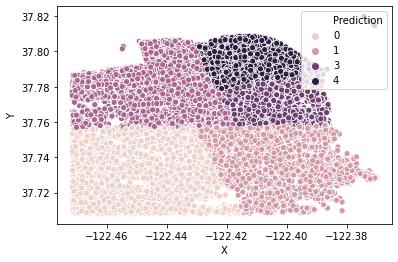

In [0]:
# display cluster
sb.scatterplot(data = transformed_pd, x = "X", y = "Y", hue = "Prediction")
plt.show()


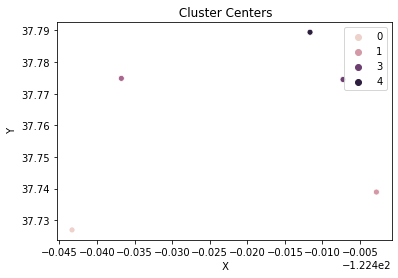

In [0]:
X_pos= [pos[0] for pos in model.clusterCenters()]
Y_pos= [pos[1] for pos in model.clusterCenters()]
ax= sb.scatterplot(x=X_pos,y=Y_pos, hue=[0,1,2,3,4] )
ax.set_xlabel(" X")
ax.set_ylabel(" Y")
ax.set_title(" Cluster Centers")
plt.show()

In [0]:
from  pyspark.ml.feature import StringIndexer
stringIndexer = StringIndexer()
stringIndexer.setInputCols(["category"])
stringIndexer.setOutputCols(["indexed_category"])
model = stringIndexer.fit(crime_cluster_df.select(["category"]))
td = model.transform(cluster_df)
display(td)

--------------------------------------------------------------------------- 
 AnalysisException Traceback (most recent call last)
 <command-1794094309151989> in <module> 
 3 stringIndexer . setInputCols ( [ "category" ] ) 
 4 stringIndexer . setOutputCols ( [ "indexed_category" ] ) 
 ----> 5 model = stringIndexer . fit ( crime_cluster_df . select ( [ "category" ] ) ) 
 6 td = model . transform ( cluster_df ) 
 7 display ( td ) 

 /databricks/spark/python/pyspark/sql/dataframe.py in select (self, *cols) 
 1690 [ Row ( name = 'Alice' , age = 12 ) , Row ( name = 'Bob' , age = 15 ) ] 
 1691 """
 -> 1692 jdf = self . _jdf . select ( self . _jcols ( * cols ) ) 
 1693 return DataFrame ( jdf , self . sql_ctx ) 
 1694 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1302 
 1303 answer = self . gateway_client . send_command ( command ) 
 -> 1304 return_value = get_return_value(
 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 121 # Hide where the exception came from that shows a non-Pythonic 
 122 # JVM exception message. 
 --> 123 raise converted from None 
 124 else : 
 125 raise 

 AnalysisException : cannot resolve '`category`' given input columns: [X, Y, features];
'Project ['category]
+- Project [X#361, Y#402, UDF(struct(X, X#361, Y, Y#402)) AS features#1042]
 +- Project [X#361, Y#402]
 +- Filter ((Y#402 >= 37.70685136133659) AND (Y#402 <= 37.8313413958422))
 +- Filter ((X#361 >= -122.47150932008998) AND (X#361 <= -122.36822339057801))
 +- Project [X#361, Y#402]
 +- Project [Hour#127, PdDistrict#65, X#361, Y#402, DayOfWeek#62, category#60, Resolution#66, hasCriminal#320]
 +- Filter (hasCriminal#320 = true)
 +- Project [PdId#57, IncidntNum#58, Incident Code#59, Category#60, Descript#61, DayOfWeek#62, Date#203, Time#64, PdDistrict#65, Resolution#66, Address#67, X#361, Y#402, location#70, SF Find Neighborhoods 2 2#71, Current Police Districts 2 2#72, Current Supervisor Districts 2 2#73, Analysis Neighborhoods 2 2#74, DELETE - Fire Prevention Districts 2 2#75, DELETE - Police Districts 2 2#76, DELETE - Supervisor Districts 2 2#77, DELETE - Zip Codes 2 2#78, DELETE - Neighborhoods 2 2#79, DELETE - 2017 Fix It Zones 2 2#80, ... 17 more fields]
 +- Filter NOT (PdDistrict#65 = NA)
 +- Project [PdId#57, IncidntNum#58, Incident Code#59, Category#60, Descript#61, DayOfWeek#62, Date#203, Time#64, PdDistrict#65, Resolution#66, Address#67, X#361, cast(Y#69 as double) AS Y#402, location#70, SF Find Neighborhoods 2 2#71, Current Police Districts 2 2#72, Current Supervisor Districts 2 2#73, Analysis Neighborhoods 2 2#74, DELETE - Fire Prevention Districts 2 2#75, DELETE - Police Districts 2 2#76, DELETE - Supervisor Districts 2 2#77, DELETE - Zip Codes 2 2#78, DELETE - Neighborhoods 2 2#79, DELETE - 2017 Fix It Zones 2 2#80, ... 16 more fields]
 +- Project [PdId#57, IncidntNum#58, Incident Code#59, Category#60, Descript#61, DayOfWeek#62, Date#203, Time#64, PdDistrict#65, Resolution#66, Address#67, cast(X#68 as double) AS X#361, Y#69, location#70, SF Find Neighborhoods 2 2#71, Current Police Districts 2 2#72, Current Supervisor Districts 2 2#73, Analysis Neighborhoods 2 2#74, DELETE - Fire Prevention Districts 2 2#75, DELETE - Police Districts 2 2#76, DELETE - Supervisor Districts 2 2#77, DELETE - Zip Codes 2 2#78, DELETE - Neighborhoods 2 2#79, DELETE - 2017 Fix It Zones 2 2#80, ... 16 more fields]
 +- Project [PdId#57, IncidntNum#58, Incident Code#59, Category#60, Descript#61, DayOfWeek#62, Date#203, Time#64, PdDistrict#65, Resolution#66, Address#67, X#68, Y#69, location#70, SF Find Neighborhoods 2 2#71, Current Police Districts 2 2#72, Current Supervisor Districts 2 2#73, Analysis Neighborhoods 2 2#74, DELETE - Fire Prevention Districts 2 2#75, DELETE - Police Districts 2 2#76, DELETE - Supervisor Districts 2 2#77, DELETE - Zip Codes 2 2#78, DELETE - Neighborhoods 2 2#79, DELETE - 2017 Fix It Zones 2 2#80, 

####Analysis:  
From the scatter plot above, we can see that 5 clusters adjacent to each other around -122.42~-122.40 in X axis and 37.36~37.78 in Y axis and some centers of clusters get close to each other in this region. This tells us that this region has the most amount of crimes
From the area of each cluster, we can see that clusters 3 and 4 have the smallest areas, which mean crimes occur in these two region more frequently than other centers
####Business Insights:  
more polices should be assigned to the regions of clusters 3 and 4 and polices in these two regions may need more equipments used to resolve crimes, such as handcuffs, siren and people live in these regions should prepare more devices to protect themseleves from crimes. We can sell these devices and equipments to these region
The figures also tell us to avoid traveling those regions as well and the amount of visitors in clusters 0 and 1 may be more than amount in other clusters due to the amount of crimes in regions of clusters 3,4.

### Time series analysis
This part is not based on Spark, and only based on Pandas Time Series package.   
   
process:  
1.visualize time series  
2.plot ACF and find optimal parameter  
3.Train ARIMA  
4.Prediction

In [0]:
display(df_opt)

PdId IncidntNum Incident Code Category Descript DayOfWeek Date Time PdDistrict Resolution Address X Y location SF Find Neighborhoods 2 2 Current Police Districts 2 2 Current Supervisor Districts 2 2 Analysis Neighborhoods 2 2 DELETE - Fire Prevention Districts 2 2 DELETE - Police Districts 2 2 DELETE - Supervisor Districts 2 2 DELETE - Zip Codes 2 2 DELETE - Neighborhoods 2 2 DELETE - 2017 Fix It Zones 2 2 Civic Center Harm Reduction Project Boundary 2 2 Fix It Zones as of 2017-11-06 2 2 DELETE - HSOC Zones 2 2 Fix It Zones as of 2018-02-07 2 2 CBD, BID and GBD Boundaries as of 2017 2 2 Areas of Vulnerability, 2016 2 2 Central Market/Tenderloin Boundary 2 2 Central Market/Tenderloin Boundary Polygon - Updated 2 2 HSOC Zones as of 2018-06-05 2 2 OWED Public Spaces 2 2 Neighborhoods 2 Hour Month Year Day HasCriminal downtown 3114751606302 031147516 06302 LARCENY/THEFT PETTY THEFT FROM A BUILDING Sunday 2003-09-28 10:00 SOUTHERN NONE 1ST ST / BRANNAN ST -120.5 90.0 POINT (-120.50000000000001 90) null null null null null null null null null null null null null null null null null null null null null 10 09 2003 28 true Outside Downtown 5069701104134 050697011 04134 ASSAULT BATTERY Wednesday 2005-06-22 12:20 NORTHERN NONE 1200 Block of EDDY ST -122.428223303176 37.7818959488603 POINT (-122.42822330317601 37.7818959488603) 97 4 11 39 7 9 11 29490 41 null null null null null null 2 null null null null 97 12 06 2005 22 true Outside Downtown 6074729204104 060747292 04104 ASSAULT ASSAULT Saturday 2006-07-15 00:55 CENTRAL NONE 1600 Block of POWELL ST -122.410672425337 37.799788690123 POINT (-122.41067242533701 37.799788690123) 106 6 3 6 3 1 10 308 4 null null null null null null 2 null null null null 106 0 07 2006 15 true Outside Downtown 7103536315201 071035363 15201 ASSAULT STALKING Tuesday 2007-09-25 00:01 TARAVAL NONE 400 Block of ULLOA ST -122.458226300605 37.7413616001449 POINT (-122.458226300605 37.7413616001449) 49 10 8 41 1 8 4 59 40 null null null null null null 1 null null null null 49 0 09 2007 25 true Outside Downtown 11082415274000 110824152 74000 MISSING PERSON MISSING ADULT Saturday 2011-09-24 11:00 TARAVAL LOCATED 3200 Block of SAN JOSE AV -122.459172646607 37.7082001648459 POINT (-122.459172646607 37.7082001648459) null null null null null null null 28588 null null null null null null null null null null null null null 11 09 2011 24 true Outside Downtown 4037801104134 040378011 04134 ASSAULT BATTERY Friday 2003-12-12 12:00 SOUTHERN NONE 500 Block of I-80 -122.386667033903 37.7898821569191 POINT (-122.38666703390301 37.7898821569191) null null null null null null null 28856 null null null null null null null null null null null null null 12 12 2003 12 true Outside Downtown 4147669007025 041476690 07025 VEHICLE THEFT STOLEN TRUCK Thursday 2004-12-30 19:00 BAYVIEW NONE 100 Block of KAREN CT -122.407531316146 37.723291086507 POINT (-122.40753131614602 37.723291086507) 91 2 2 25 10 3 7 309 28 null null null null null null 1 null null null null 91 19 12 2004 30 true Outside Downtown 18030800164070 180308001 64070 SUSPICIOUS OCC SUSPICIOUS OCCURRENCE Wednesday 2018-04-25 05:00 BAYVIEW NONE 1400 Block of THOMAS AV -122.38854283127222 37.72878928885484 POINT (-122.38854283127222 37.72878928885484) 86 2 9 1 10 3 8 58 1 null null null null null null 2 null null null null 86 5 04 2018 25 true Outside Downtown 18023216504170 180232165 04170 ASSAULT FALSE IMPRISONMENT Saturday 2018-03-24 07:00 MISSION NONE MISSION ST / 20TH ST -122.41905269434928 37.75863240515618 POINT (-122.41905269434928 37.75863240515618) 53 3 2 20 2 4 7 28859 19 13 null 15 3 15 null 2 null null 3 null 53 7 03 2018 24 true Downtown 16028516271000 160285162 71000 NON-CRIMINAL LOST PROPERTY Tuesday 2016-03-01 00:01 MISSION NONE 2200 Block of MARKET ST -122.43195768519577 37.76493571896795 POINT (-122.43195768519577 37.76493571896795) 38 3 5 5 15 4 5 28862 3 null null null 5 null 9 1 null null 5 null 38 0 03 2016 1 false Outside Downtown 17103493468020 171034934 6802

In [0]:
ts = spark.sql(
"""
select Date, count(*) as number_of_crime from sf_crime
where Category = 'LARCENY/THEFT'
group by 1
order by 1
""")
display(ts)

Date number_of_crime 2003-01-01 72 2003-01-02 51 2003-01-03 65 2003-01-04 53 2003-01-05 54 2003-01-06 67 2003-01-07 50 2003-01-08 74 2003-01-09 63 2003-01-10 71 2003-01-11 50 2003-01-12 65 2003-01-13 62 2003-01-14 66 2003-01-15 66 2003-01-16 64 2003-01-17 75 2003-01-18 76 2003-01-19 58 2003-01-20 67 2003-01-21 81 2003-01-22 78 2003-01-23 64 2003-01-24 87 2003-01-25 88 2003-01-26 51 2003-01-27 72 2003-01-28 76 2003-01-29 95 2003-01-30 68 2003-01-31 75 2003-02-01 75 2003-02-02 45 2003-02-03 52 2003-02-04 64 2003-02-05 71 2003-02-06 73 2003-02-07 85 2003-02-08 77 2003-02-09 71 2003-02-10 69 2003-02-11 73 2003-02-12 73 2003-02-13 75 2003-02-14 75 2003-02-15 67 2003-02-16 85 2003-02-17 70 2003-02-18 77 2003-02-19 80 2003-02-20 73 2003-02-21 79 2003-02-22 83 2003-02-23 75 2003-02-24 71 2003-02-25 81 2003-02-26 85 2003-02-27 92 2003-02-28 83 2003-03-01 88 2003-03-02 60 2003-03-03 71 2003-03-04 79 2003-03-05 70 2003-03-06 65 2003-03-07 96 2003-03-08 86 2003-03-09 70 2003-03-10 67 2003-03-11 80 2003-03-12 83 2003-03-13 79 2003-03-14 84 2003-03-15 89 2003-03-16 76 2003-03-17 70 2003-03-18 66 2003-03-19 64 2003-03-20 79 2003-03-21 82 2003-03-22 76 2003-03-23 80 2003-03-24 84 2003-03-25 90 2003-03-26 79 2003-03-27 77 2003-03-28 92 2003-03-29 97 2003-03-30 70 2003-03-31 63 2003-04-01 84 2003-04-02 70 2003-04-03 73 2003-04-04 82 2003-04-05 92 2003-04-06 82 2003-04-07 69 2003-04-08 79 2003-04-09 82 2003-04-10 86 2003-04-11 95 2003-04-12 81 2003-04-13 75 2003-04-14 79 2003-04-15 76 2003-04-16 71 2003-04-17 69 2003-04-18 87 2003-04-19 78 2003-04-20 85 2003-04-21 66 2003-04-22 91 2003-04-23 79 2003-04-24 63 2003-04-25 96 2003-04-26 92 2003-04-27 67 2003-04-28 71 2003-04-29 62 2003-04-30 61 2003-05-01 68 2003-05-02 72 2003-05-03 64 2003-05-04 57 2003-05-05 50 2003-05-06 71 2003-05-07 63 2003-05-08 74 2003-05-09 76 2003-05-10 77 2003-05-11 52 2003-05-12 75 2003-05-13 70 2003-05-14 53 2003-05-15 68 2003-05-16 77 2003-05-17 65 2003-05-18 82 2003-05-19 76 2003-05-20 72 2003-05-21 68 2003-05-22 74 2003-05-23 75 2003-05-24 72 2003-05-25 58 2003-05-26 64 2003-05-27 75 2003-05-28 77 2003-05-29 74 2003-05-30 72 2003-05-31 68 2003-06-01 69 2003-06-02 66 2003-06-03 76 2003-06-04 68 2003-06-05 64 2003-06-06 83 2003-06-07 71 2003-06-08 74 2003-06-09 69 2003-06-10 78 2003-06-11 88 2003-06-12 78 2003-06-13 72 2003-06-14 58 2003-06-15 66 2003-06-16 70 2003-06-17 81 2003-06-18 83 2003-06-19 77 2003-06-20 103 2003-06-21 70 2003-06-22 62 2003-06-23 82 2003-06-24 73 2003-06-25 91 2003-06-26 82 2003-06-27 76 2003-06-28 75 2003-06-29 76 2003-06-30 66 2003-07-01 76 2003-07-02 83 2003-07-03 92 2003-07-04 61 2003-07-05 70 2003-07-06 68 2003-07-07 61 2003-07-08 64 2003-07-09 66 2003-07-10 63 2003-07-11 74 2003-07-12 61 2003-07-13 67 2003-07-14 64 2003-07-15 84 2003-07-16 74 2003-07-17 97 2003-07-18 94 2003-07-19 95 2003-07-20 83 2003-07-21 82 2003-07-22 74 2003-07-23 72 2003-07-24 76 2003-07-25 80 2003-07-26 82 2003-07-27 57 2003-07-28 55 2003-07-29 56 2003-07-30 59 2003-07-31 65 2003-08-01 64 2003-08-02 58 2003-08-03 57 2003-08-04 57 2003-08-05 76 2003-08-06 81 2003-08-07 71 2003-08-08 75 2003-08-09 91 2003-08-10 76 2003-08-11 70 2003-08-12 79 2003-08-13 80 2003-08-14 80 2003-08-15 91 2003-08-16 88 2003-08-17 64 2003-08-18 67 2003-08-19 67 2003-08-20 71 2003-08-21 74 2003-08-22 77 2003-08-23 75 2003-08-24 67 2003-08-25 74 2003-08-26 74 2003-08-27 76 2003-08-28 71 2003-08-29 68 2003-08-30 64 2003-08-31 63 2003-09-01 56 2003-09-02 65 2003-09-03 65 2003-09-04 64 2003-09-05 91 2003-09-06 72 2003-09-07 72 2003-09-08 60 2003-09-09 83 2003-09-10 71 2003-09-11 65 2003-09-12 74 2003-09-13 81 2003-09-14 68 2003-09-15 72 2003-09-16 53 2003-09-17 77 2003-09-18 72 2003-09-19 82 2003-09-20 79 2003-09-21 72 2003-09-22 77 2003-09-23 73 2003-09-24 76 2003-09-25 72 2003-09-26 84 2003-09-27 79 2003-09-28 71 2003-09-29 55 2003-09-30 79 2003-10-01 72 2003-10-02 63 2003-10-03 64 2003-10-04 56 2003-10-05 73 2003-10-06 63 2003-10-07 76 2003-10-08 71 2003-10-09 74 2003-10-10 81 2003-10-11 72 20

In [0]:
ts_m = spark.sql(
  """
  SELECT concat(year,"-", month, "-01") as year_month, COUNT(*) AS count 
  FROM (select * from sf_crime 
  where Category = 'LARCENY/THEFT'
  except
  SELECT * FROM sf_crime 
  where Category = 'LARCENY/THEFT'
  and year = '2018' 
  and month = '05')
  GROUP BY year_month 
  Order BY year_month
  """)
display(ts_m)

year_month count 2003-01-01 2104 2003-02-01 2079 2003-03-01 2412 2003-04-01 2343 2003-05-01 2139 2003-06-01 2247 2003-07-01 2255 2003-08-01 2246 2003-09-01 2160 2003-10-01 2205 2003-11-01 2082 2003-12-01 1913 2004-01-01 2102 2004-02-01 1916 2004-03-01 1952 2004-04-01 2045 2004-05-01 2084 2004-06-01 2208 2004-07-01 2314 2004-08-01 2155 2004-09-01 2038 2004-10-01 1919 2004-11-01 1689 2004-12-01 1915 2005-01-01 2027 2005-02-01 1724 2005-03-01 2022 2005-04-01 1913 2005-05-01 2177 2005-06-01 2246 2005-07-01 2300 2005-08-01 2397 2005-09-01 2195 2005-10-01 2160 2005-11-01 1993 2005-12-01 2072 2006-01-01 2337 2006-02-01 2060 2006-03-01 2329 2006-04-01 2381 2006-05-01 2330 2006-06-01 2260 2006-07-01 2200 2006-08-01 2394 2006-09-01 2291 2006-10-01 2379 2006-11-01 2104 2006-12-01 2162 2007-01-01 1959 2007-02-01 1620 2007-03-01 2043 2007-04-01 2008 2007-05-01 2108 2007-06-01 2181 2007-07-01 2526 2007-08-01 2459 2007-09-01 2376 2007-10-01 2282 2007-11-01 2017 2007-12-01 2020 2008-01-01 2143 2008-02-01 1875 2008-03-01 2207 2008-04-01 2325 2008-05-01 2145 2008-06-01 1960 2008-07-01 2188 2008-08-01 2172 2008-09-01 2211 2008-10-01 2408 2008-11-01 2057 2008-12-01 1945 2009-01-01 1919 2009-02-01 1836 2009-03-01 2181 2009-04-01 2035 2009-05-01 1968 2009-06-01 1851 2009-07-01 2319 2009-08-01 2499 2009-09-01 2295 2009-10-01 2226 2009-11-01 2143 2009-12-01 2147 2010-01-01 2088 2010-02-01 1683 2010-03-01 1901 2010-04-01 1774 2010-05-01 1920 2010-06-01 1944 2010-07-01 2103 2010-08-01 2271 2010-09-01 2158 2010-10-01 2117 2010-11-01 2155 2010-12-01 2098 2011-01-01 2075 2011-02-01 1900 2011-03-01 2235 2011-04-01 2016 2011-05-01 2191 2011-06-01 2009 2011-07-01 2085 2011-08-01 2130 2011-09-01 2058 2011-10-01 2307 2011-11-01 2219 2011-12-01 2404 2012-01-01 2187 2012-02-01 2086 2012-03-01 2098 2012-04-01 2311 2012-05-01 2537 2012-06-01 2490 2012-07-01 2550 2012-08-01 2840 2012-09-01 2958 2012-10-01 3128 2012-11-01 2847 2012-12-01 2728 2013-01-01 2916 2013-02-01 2656 2013-03-01 2846 2013-04-01 2883 2013-05-01 2690 2013-06-01 2701 2013-07-01 3302 2013-08-01 3468 2013-09-01 3590 2013-10-01 3359 2013-11-01 3017 2013-12-01 2788 2014-01-01 2926 2014-02-01 2540 2014-03-01 3011 2014-04-01 3007 2014-05-01 2815 2014-06-01 2738 2014-07-01 3179 2014-08-01 3635 2014-09-01 3251 2014-10-01 3621 2014-11-01 3484 2014-12-01 3653 2015-01-01 3705 2015-02-01 3276 2015-03-01 3811 2015-04-01 3478 2015-05-01 3837 2015-06-01 3749 2015-07-01 3873 2015-08-01 3694 2015-09-01 3422 2015-10-01 3264 2015-11-01 2939 2015-12-01 2932 2016-01-01 3459 2016-02-01 3198 2016-03-01 2959 2016-04-01 2870 2016-05-01 3396 2016-06-01 3356 2016-07-01 3410 2016-08-01 3321 2016-09-01 3352 2016-10-01 3749 2016-11-01 3460 2016-12-01 3834 2017-01-01 3852 2017-02-01 3618 2017-03-01 3846 2017-04-01 3757 2017-05-01 4065 2017-06-01 4083 2017-07-01 4158 2017-08-01 3820 2017-09-01 3781 2017-10-01 4457 2017-11-01 4218 2017-12-01 4059 2018-01-01 3816 2018-02-01 2906 2018-03-01 3100 2018-04-01 2919

In [0]:
test = spark.sql("""
SELECT * FROM sf_crime 
  where Category = 'LARCENY/THEFT'
  and year = '2013' 
  and month = '01'
  order by day 
  """)
display(test)

PdId IncidntNum Incident Code Category Descript DayOfWeek Date Time PdDistrict Resolution Address X Y location SF Find Neighborhoods 2 2 Current Police Districts 2 2 Current Supervisor Districts 2 2 Analysis Neighborhoods 2 2 DELETE - Fire Prevention Districts 2 2 DELETE - Police Districts 2 2 DELETE - Supervisor Districts 2 2 DELETE - Zip Codes 2 2 DELETE - Neighborhoods 2 2 DELETE - 2017 Fix It Zones 2 2 Civic Center Harm Reduction Project Boundary 2 2 Fix It Zones as of 2017-11-06 2 2 DELETE - HSOC Zones 2 2 Fix It Zones as of 2018-02-07 2 2 CBD, BID and GBD Boundaries as of 2017 2 2 Areas of Vulnerability, 2016 2 2 Central Market/Tenderloin Boundary 2 2 Central Market/Tenderloin Boundary Polygon - Updated 2 2 HSOC Zones as of 2018-06-05 2 2 OWED Public Spaces 2 2 Neighborhoods 2 Hour Month Year Day HasCriminal downtown 13000264506113 130002645 06113 LARCENY/THEFT GRAND THEFT PICKPOCKET Tuesday 2013-01-01 02:00 MISSION NONE 2700 Block of 25TH ST -122.405728477989 37.7518107680228 POINT (-122.405728477989 37.7518107680228) 54 3 9 20 10 4 8 28859 19 23 null 10 null 10 null 1 null null null null 54 2 01 2013 1 true Outside Downtown 13600082306372 136000823 06372 LARCENY/THEFT PETTY THEFT OF PROPERTY Tuesday 2013-01-01 00:01 SOUTHERN NONE 1500 Block of MISSION ST -122.417523396516 37.7738670346175 POINT (-122.417523396516 37.7738670346175) 32 1 10 20 8 2 9 28853 19 null 1 null 1 null 7 2 1 1 1 null 32 0 01 2013 1 true Downtown 13000164706304 130001647 06304 LARCENY/THEFT GRAND THEFT FROM A BUILDING Tuesday 2013-01-01 11:15 SOUTHERN NONE 1200 Block of MARKET ST -122.415448759562 37.778293520129 POINT (-122.41544875956198 37.778293520129) 21 5 10 36 7 2 9 28852 36 null 1 null 1 null 7 2 1 1 1 35 21 11 01 2013 1 true Outside Downtown 13600396806372 136003968 06372 LARCENY/THEFT PETTY THEFT OF PROPERTY Tuesday 2013-01-01 00:15 CENTRAL NONE 300 Block of JEFFERSON ST -122.418270696719 37.8078519838014 POINT (-122.41827069671899 37.8078519838014) 99 6 3 23 5 1 10 308 23 null null null null null 2 2 null null null null 99 0 01 2013 1 true Outside Downtown 13601489606372 136014896 06372 LARCENY/THEFT PETTY THEFT OF PROPERTY Tuesday 2013-01-01 14:55 PARK NONE 900 Block of ASHBURY ST -122.445790251499 37.7646916029501 POINT (-122.44579025149902 37.7646916029501) 112 7 5 3 15 5 5 29492 9 null null null null null null 1 null null null null 112 14 01 2013 1 true Outside Downtown 14000130806244 140001308 06244 LARCENY/THEFT GRAND THEFT FROM LOCKED AUTO Tuesday 2013-01-01 05:00 SOUTHERN NONE 1100 Block of HOWARD ST -122.409605982336 37.7777263414712 POINT (-122.409605982336 37.7777263414712) 32 1 10 34 8 2 9 28853 34 24 1 6 1 6 null 2 null null 1 null 32 5 01 2013 1 true Outside Downtown 13002157606223 130021576 06223 LARCENY/THEFT PETTY THEFT FROM UNLOCKED AUTO Tuesday 2013-01-01 16:30 SOUTHERN NONE 300 Block of MAIN ST -122.391024911564 37.7887786674397 POINT (-122.39102491156399 37.7887786674397) 30 1 10 8 6 2 9 28855 6 null null null null null 3 1 null null null null 30 16 01 2013 1 true Outside Downtown 13000151206113 130001512 06113 LARCENY/THEFT GRAND THEFT PICKPOCKET Tuesday 2013-01-01 01:30 NORTHERN NONE 1200 Block of POLK ST -122.420326993863 37.7884521578132 POINT (-122.420326993863 37.7884521578132) 50 4 3 21 13 9 10 28858 21 null null null null null 10 2 null null null null 50 1 01 2013 1 true Outside Downtown 13600971206372 136009712 06372 LARCENY/THEFT PETTY THEFT OF PROPERTY Tuesday 2013-01-01 14:00 SOUTHERN NONE BERRY ST / 7TH ST -122.40002612049 37.7705161444903 POINT (-122.40002612049 37.7705161444903) 34 1 9 4 14 2 8 28856 20 null null null null null null 1 null null null null 34 14 01 2013 1 true Downtown 13600019606372 136000196 06372 LARCENY/THEFT PETTY THEFT OF PROPERTY Tuesday 2013-01-01 01:00 NORTHERN NONE 1100 Block of FILLMORE ST -122.432116233695 37.7800304351156 POINT (-122.43211623369501 37.7800304351156) 97 4 11 39 15 9 11 29490 41 null null null null null null 2 null null null null 97 1 01 2013 1 true Outside D

In [0]:
import itertools
p = d = q = range(0,2)

# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)

In [0]:
y = ts_m.toPandas()
y.set_index('year_month', inplace=True)
# set index as DataTimeIndex
y.index = pd.to_datetime(y.index)
# The 'MS' string groups the data into buckets by start of the month
y = y['count'].resample('MS').mean()
y.head()

Out[8]: year_month
2003-01-01 2104
2003-02-01 2079
2003-03-01 2412
2003-04-01 2343
2003-05-01 2139
Freq: MS, Name: count, dtype: int64

In [0]:
y = ts_m.toPandas()
y.set_index('year_month', inplace=True)
# set index as DataTimeIndex
y.index = pd.PeriodIndex(y.index)
# The 'MS' string groups the data into buckets by start of the month
y = y['count'].resample('MS').mean()
y.head()

In [0]:
%python
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

optimal = {'param':None, 'param_seasonal':None, 'aic':None}
for param in pdq:
  for param_seasonal in seasonal_pdq:
    try:
      mod = sm.tsa.statespace.SARIMAX(y,
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)

      results = mod.fit()
      if (not optimal['aic']) or results.aic < optimal['aic']:
        optimal['param'] = param
        optimal['param_seasonal'] = param_seasonal
        optimal['aic'] = results.aic
        print('optimal updated')
      print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
    except:
      continue
print('optimal paramaters:', optimal)

optimal updated
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3410.3935084929767
optimal updated
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3004.6138886775143
optimal updated
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2535.7763991229976
optimal updated
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2360.124969551746
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2540.036261070695
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2497.5934566049764
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2368.050435451124
optimal updated
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2351.288557875925
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3166.471524714587
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2809.502172785422
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2419.4118120211806
optimal updated
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2241.8082138189293
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2442.949005721268
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2374.541626188287
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2260.6117631782354
optimal updated
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2233.5945842294104
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2499.1856112191454
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2318.7910155719546
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:2347.9688353504566
optimal updated
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:2125.8616787761794
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:2319.991898870262
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:2289.3416504791176
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:2171.9498298844755
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:2127.4931285667412
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:2474.995162857302
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2302.782098282675
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:2334.4177382652183
optimal updated
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:2114.3894547808877
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:2318.9748157339673
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2276.1376874876523
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:2173.6580286918597
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:2115.9421360832007
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:2513.8020548225822
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:2333.7723826397482
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:2349.0126814279765
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:2137.3764892681775
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:2321.1450417268916
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:2297.570643036132
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:2161.544815361048
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:2139.007226085024
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:2491.787617098971
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2317.3527047632642
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:2337.764956840693
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:2125.804277485402
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:2320.394812938851
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2284.8884873819306
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:2163.086966597106
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:2127.3084274575176
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:2490.52341470714
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:2315.075337096126
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:2348.996816216187
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:2127.858805525753
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:2305.8372577363307
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:2291.3410022312164
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:2160.3575252625765
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:2129.4882493693867
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:2475.11759145612
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2302.710923929051
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:2325.605756627053
optimal updated
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:2111.4916843717015
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:2304.0209206013587
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2275.1552906270863
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:2150.1691217342172
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:2113.440856242698
optimal paramaters: {'param': (1, 1, 1), 'param_seasonal': (0, 1, 1, 12), 'aic': 2111.4916843717015}

In [0]:
%python
optimal

Out[10]: {'param': (1, 1, 1),
 'param_seasonal': (0, 1, 1, 12),
 'aic': 2111.4916843717015}

In [0]:
mod = sm.tsa.statespace.SARIMAX(y, order = optimal['param'],
                               seasonal_order = optimal['param_seasonal'],
                               enforce_stationarity = False,
                               enforce_invertibility = False)

result = mod.fit()
print(results.summary().tables[1])

==============================================================================
 coef std err z P>|z| [0.025 0.975]
------------------------------------------------------------------------------
ar.L1 0.7765 0.104 7.434 0.000 0.572 0.981
ma.L1 -0.9161 0.071 -12.836 0.000 -1.056 -0.776
ar.S.L12 0.0240 0.115 0.209 0.835 -0.201 0.249
ma.S.L12 -1.1774 0.155 -7.590 0.000 -1.481 -0.873
sigma2 2.62e+04 7314.569 3.582 0.000 1.19e+04 4.05e+04
==============================================================================

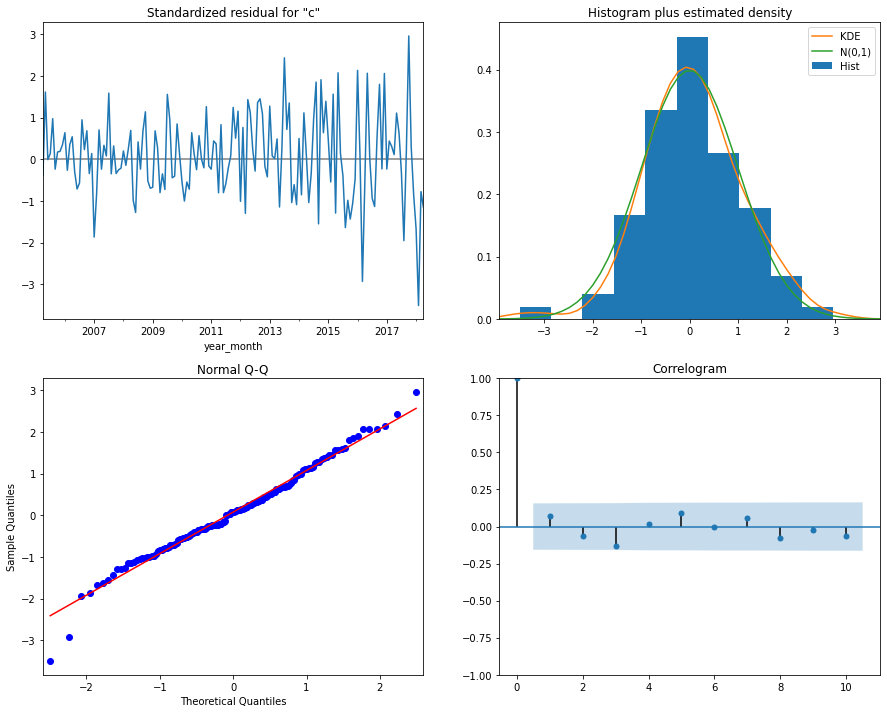

In [0]:
results.plot_diagnostics(figsize= (15,12))
plt.show()

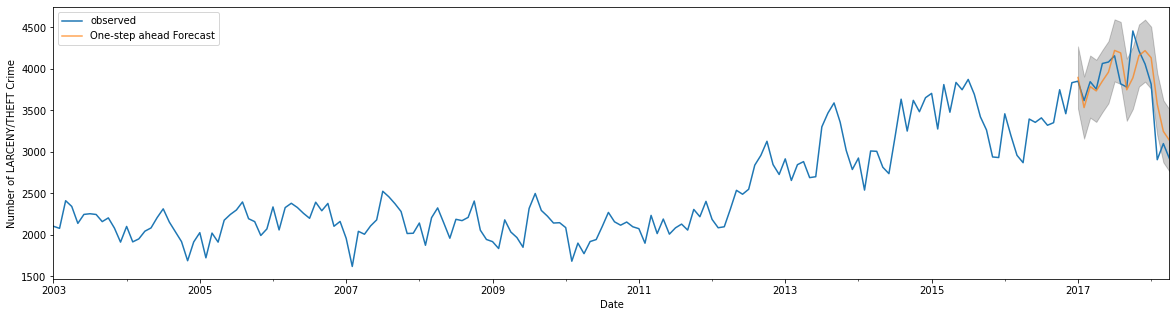

In [0]:

pred = results.get_prediction(start = pd.to_datetime("2017-01-01"), dynamic= False)
pred_ci = pred.conf_int()
ax = y.plot(label='observed', figsize = (20,5))
pred.predicted_mean.plot(ax = ax, label="One-step ahead Forecast", alpha = 0.7)
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1], 
               color = 'k', alpha= 0.2)
ax.set_xlabel('Date')
ax.set_ylabel('Number of LARCENY/THEFT Crime')
plt.legend()
plt.show()

In [0]:
y_forecasted= pred.predicted_mean
y_truth = y['2018-04-01':]
mse = ((y_forecasted-y_truth) **2).mean()
print("The Mean Squared Error of our forecasts is ", mse)

The Mean Squared Error of our forecasts is 48148.35148849279